In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay, make_scorer, roc_auc_score, auc

# Хакатон Wildberries&Цифровая кафедра 2025

Команда №7:

Грибов Кирилл

Давыдова Алиса

Исаева Дарья

Кацко Анастасия

### Общий вид данных

In [ ]:
df_train=pd.read_csv('/Users/sergegribo/Desktop/ML/ВБ хакатон/data/df_train.csv', sep=',')
df_test = pd.read_csv('/Users/sergegribo/Desktop/ML/ВБ хакатон/data/df_test.csv', sep=',')
df_train.head() #первые пять строк

user_id  nm_id                CreatedDate service  total_ordered  \
0        1      1  2025-01-05 02:20:24+03:00    nnsz            627   
1        2      2  2024-11-05 09:05:21+03:00    nnsz            512   
2        3      3  2024-12-11 13:45:33+03:00    nnsz            500   
3        4      4  2025-01-24 07:47:34+03:00    nnsz            452   
4        5      5  2024-11-27 11:50:43+03:00    nnsz            450   

  PaymentType  IsPaid  count_items  unique_items  avg_unique_purchase  ...  \
0         CSH   False            4             4                 1.00  ...   
1         CRD    True            0             0                 0.00  ...   
2         CRD    True            0             0                 0.00  ...   
3         CSH   False            6             2                 0.33  ...   
4         CRD    True            0             0                 0.00  ...   

   NmAge  Distance  DaysAfterRegistration  number_of_orders  \
0    117      3443                     73                 1   
1    920      3478                   1237                 2   
2    420       771                   4003                 1   
3  20112       763                    977                 5   
4    141      1089                   1637                 3   

   number_of_ordered_items  mean_number_of_ordered_items  \
0                      627                         627.0   
1                      606                         303.0   
2                      500                         500.0   
3                     1102                         220.4   
4                      549                         183.0   

   min_number_of_ordered_items  max_number_of_ordered_items  \
0                          627                          627   
1                           94                          512   
2                          500                          500   
3                          100                          452   
4                            1                          450   

   mean_percent_of_ordered_items  target  
0                     100.000000       0  
1                      50.000000       0  
2                     100.000000       0  
3                      20.000000       0  
4                      33.333333       0  

[5 rows x 21 columns]

In [4]:
df_train.columns # существующие поля со значениями

Index(['user_id', 'nm_id', 'CreatedDate', 'service', 'total_ordered',
       'PaymentType', 'IsPaid', 'count_items', 'unique_items',
       'avg_unique_purchase', 'is_courier', 'NmAge', 'Distance',
       'DaysAfterRegistration', 'number_of_orders', 'number_of_ordered_items',
       'mean_number_of_ordered_items', 'min_number_of_ordered_items',
       'max_number_of_ordered_items', 'mean_percent_of_ordered_items',
       'target'],
      dtype='object')

In [5]:
print('Размерность данных df_train', df_train.shape)
print('Размерность данных df_test', df_test.shape)

Размерность данных df_train (105565, 21)
Размерность данных df_test (14261, 21)


### Структура датасета


   <li> user_id - идентификатор пользователя <br> </li>
   <br>
   <li> created_date - дата создания записи <br> </li>
   <br>
   <li> nm_id - идентификатор товара <br> </li>
   <br>
   <li> total_ordered - общее количество заказанных товаров <br> </li>
   <br>
   <li> payment_type - тип оплаты <br> </li>
   <br>
   <li> is_paid - флаг оплаты <br> </li>
   <br>
   <li> count_items - количество товаров за последнее время <br> </li>
   <br>
   <li> unique_items - количество уникальных товаров за последнее время <br> </li>
   <br>
   <li> avg_unique_purchase - среднее количество уникальных покупок за последнее время <br> </li>
   <br>
   <li> is_courier - флаг доставки курьером <br> </li>
   <br>
   <li> nm_age - возраст товара <br> </li>
   <br>
   <li> Distance - расстояние <br> </li>
   <br>
   <li> days_after_registration - дни после регистрации <br> </li>
   <br>
   <li> number_of_orders - количество заказов <br> </li>
   <br>
   <li> number_of_ordered_items - количество заказанных товаров <br> </li>
   <br>
   <li> mean_number_of_ordered_items - среднее количество заказанных товаров <br> </li>
   <br>
   <li> min_number_of_ordered_items - минимальное количество заказанных товаров <br> </li>
   <br>
   <li> max_number_of_ordered_items - максимальное количество заказанных товаров <br> </li>
   <br>
   <li> mean_percent_of_ordered_items - средний процент заказанных товаров <br> </li>
   <br>
   <li> target - целевая переменная (0 - не требуется блокировка, 1 - требуется блокировка) <br> </li>
   <br>
   <li> service - тип региона <br> </li>


In [6]:
df_train.info() #общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105565 entries, 0 to 105564
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_id                        105565 non-null  int64  
 1   nm_id                          105565 non-null  int64  
 2   CreatedDate                    105565 non-null  object 
 3   service                        105565 non-null  object 
 4   total_ordered                  105565 non-null  int64  
 5   PaymentType                    105565 non-null  object 
 6   IsPaid                         105565 non-null  bool   
 7   count_items                    105565 non-null  int64  
 8   unique_items                   105565 non-null  int64  
 9   avg_unique_purchase            105565 non-null  float64
 10  is_courier                     105565 non-null  int64  
 11  NmAge                          105565 non-null  int64  
 12  Distance                      

In [11]:
#подсчет пропусков в датафрейме
missing_cols_train = df_train.isnull().sum()
missing_cols_train = missing_cols_train[missing_cols_train > 0]
print('Количество пропущенных значений в df_train', len(missing_cols_train))

missing_cols_test = df_test.isnull().sum()
missing_cols_test = missing_cols_test[missing_cols_test > 0]
print('Количество пропущенных значений в df_test', len(missing_cols_test))

Количество пропущенных значений в df_train 0
Количество пропущенных значений в df_test 0


### Cтатистика данных 

In [12]:
#статистика по признакам
df_train.describe().transpose()

count          mean           std       min  \
user_id                        105565.0  21169.816056  12481.936785  1.000000   
nm_id                          105565.0  19504.235305  13426.109359  1.000000   
total_ordered                  105565.0     30.262322     40.532477  1.000000   
count_items                    105565.0    256.541562   1023.116291  0.000000   
unique_items                   105565.0     34.933851    141.116667  0.000000   
avg_unique_purchase            105565.0      0.403886      0.406656  0.000000   
is_courier                     105565.0      0.013243      0.114314  0.000000   
NmAge                          105565.0   5518.167887   8667.012801  0.000000   
Distance                       105565.0   1554.587572   1657.277528  6.000000   
DaysAfterRegistration          105565.0   1368.405589    995.599647  0.000000   
number_of_orders               105565.0     20.504665     58.990701  1.000000   
number_of_ordered_items        105565.0    145.566902   2196.753376  1.000000   
mean_number_of_ordered_items   105565.0     30.249259     38.607053  1.000000   
min_number_of_ordered_items    105565.0     25.561417     36.717645  1.000000   
max_number_of_ordered_items    105565.0     36.207900     44.659212  1.000000   
mean_percent_of_ordered_items  105565.0     45.643031     41.786504  0.041946   
target                         105565.0      0.126500      0.332414  0.000000   

                                       25%           50%       75%       max  
user_id                        9399.000000  22640.000000  34319.00   35433.0  
nm_id                          6057.000000  20774.000000  33684.00   37224.0  
total_ordered                     1.000000     14.000000     50.00     627.0  
count_items                       0.000000     22.000000    107.00  203303.0  
unique_items                      0.000000     13.000000     39.00   19984.0  
avg_unique_purchase               0.000000      0.250000      0.86       1.0  
is_courier                        0.000000      0.000000      0.00       1.0  
NmAge                           153.000000    363.000000  20004.00   20120.0  
Distance                        472.000000   1066.000000   1995.00   13381.0  
DaysAfterRegistration           551.000000   1344.000000   1843.00    5839.0  
number_of_orders                  1.000000      3.000000     22.00    2384.0  
number_of_ordered_items          27.000000     56.000000     94.00  385200.0  
mean_number_of_ordered_items      1.649123     15.000000     50.00     627.0  
min_number_of_ordered_items       1.000000     10.000000     50.00     627.0  
max_number_of_ordered_items       3.000000     20.000000     50.00     627.0  
mean_percent_of_ordered_items     4.545455     33.333333    100.00     100.0  
target                            0.000000      0.000000      0.00       1.0

- **Разброс данных `total_ordered`** обусловлен тем, что люди за один раз заказывают небольшое количество товаров.  
  (25-й квартиль равен 1, 50-й квартиль — 14).

- **Данные `count_items`** имеют сильный разброс (стандартное отклонение — 1023.12, максимум — 203303).  
  Требуется проверить признак на выбросы.

- **Данные `unique_items`** показывают разброс: (25%-й квартиль — 0, 50%-й — 13, 75%-й — 39, максимум — 19984).  
  Необходимо проверить признак на наличие выбросов.

- **`number_of_orders`** показывает значительный разрыв между 75%-м квартилем и максимумом, а также большое стандартное отклонение.  
  Требуется проверить признак на наличие выбросов.

- Аналогично, **`mean_number_of_ordered_items`**, **`min_number_of_ordered_items`**, и **`max_number_of_ordered_items`**. 
  Есть значительная разница между 75%-м квартилем и максимумом — необходимо проверить на выбросы.


# Анализ данных (EDA):

●	Проанализировать дисбаланс (сколько объектов каждого класса)

●	Исследовать распределение признаков

●	Выявить корреляции между признаками

●	Проверить наличие пропущенных значений и выбросов

Перед тем как провести первичный анализ данных воспользуемся функцией, которая будет преобразовывать данные  
Объяснение этой функции будет приведено после EDA в части Preprocessing

In [17]:
def preprocess(df, drop_cols=True, extract_time=True, type_cast=True):
    """
    Минимальный препроцессинг данных для EDA/моделирования.
    Аргументы:
        df (pd.DataFrame): исходный DataFrame
        drop_cols (bool): удалить 'user_id', 'nm_id', 'CreatedDate'
        extract_time (bool): создать колонку 'order_hour' из 'CreatedDate'
        type_cast (bool): привести типы ('bool', 'category')
    Возвращает:
        pd.DataFrame: копия df с изменениями
    """
    df = df.copy()

    if drop_cols:
        for col in ['user_id', 'nm_id']:
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)

    if extract_time and 'CreatedDate' in df.columns:
        df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], errors='coerce')
        df['order_hour'] = df['CreatedDate'].dt.hour
        df['order_year'] = df['CreatedDate'].dt.year
        df.drop('CreatedDate', axis=1, inplace=True)

    if type_cast:
        for col in ['is_courier', 'target']:
            if col in df.columns:
                df[col] = df[col].astype('bool')

        for col in ['service', 'PaymentType']:
            if col in df.columns:
                df[col] = df[col].astype('category')

    return df

In [18]:
df_train_pr = preprocess(df_train)
df_test_pr = preprocess(df_test)

### Анализ дисбаланса классов

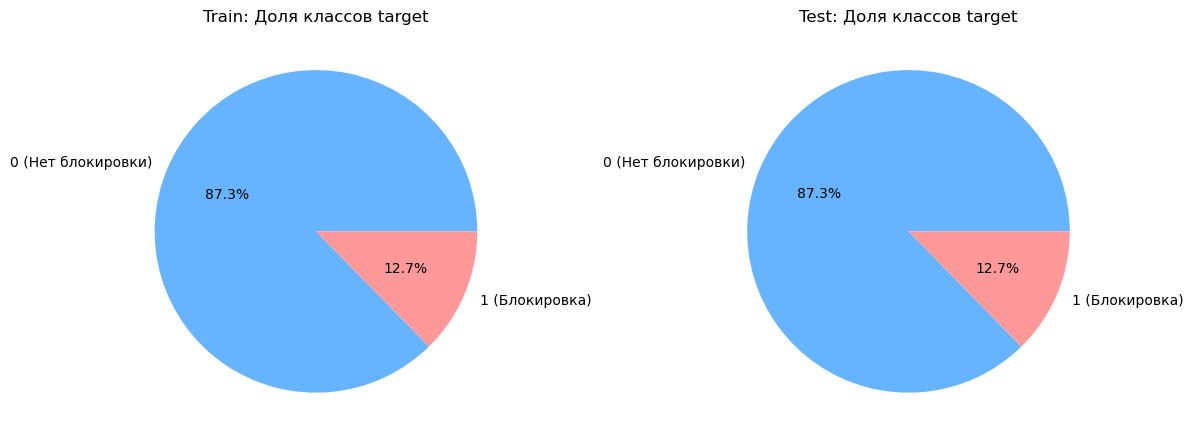

In [ ]:
# Подсчёт значений
train_counts = df_train['target'].value_counts()
test_counts = df_test['target'].value_counts()

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train pie
axes[0].pie(
    train_counts,
    autopct='%.1f%%',
    labels=['0 (Нет блокировки)', '1 (Блокировка)'],
    colors=['#66b3ff', '#ff9999']
)
axes[0].set_title('Train: Доля классов target')
axes[0].set_ylabel('')

# Test pie
axes[1].pie(
    test_counts,
    autopct='%.1f%%',
    labels=['0 (Нет блокировки)', '1 (Блокировка)'],
    colors=['#66b3ff', '#ff9999']
)
axes[1].set_title('Test: Доля классов target')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [52]:
class_counts = df_train_pr['target'].value_counts()
print(class_counts)

target
False    92211
True     13354
Name: count, dtype: int64


### Исследование распределения признаков

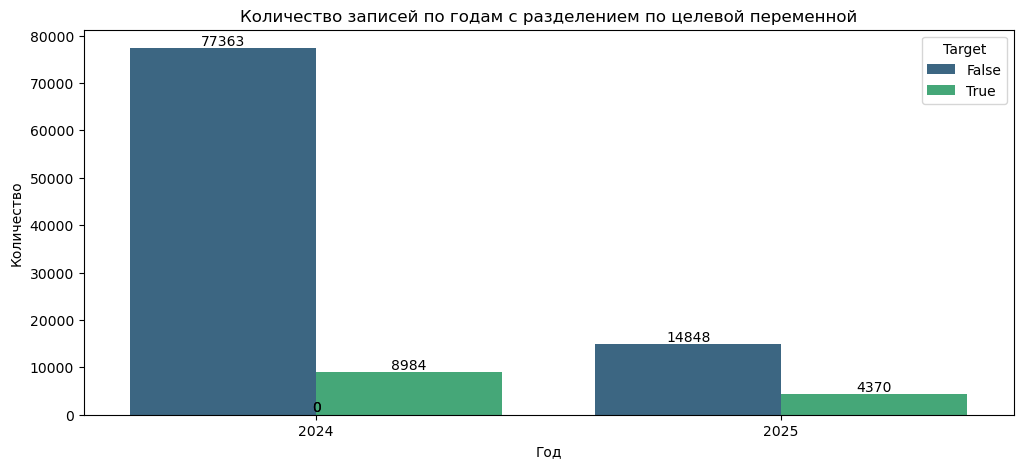

In [ ]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(data=df_train_pr, x='order_year', hue='target', palette='viridis')
plt.title('Количество записей по годам с разделением по целевой переменной')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.legend(title='Target')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}',  
                (p.get_x() + p.get_width() / 2., height),  
                ha='center', va='bottom')  

plt.show()

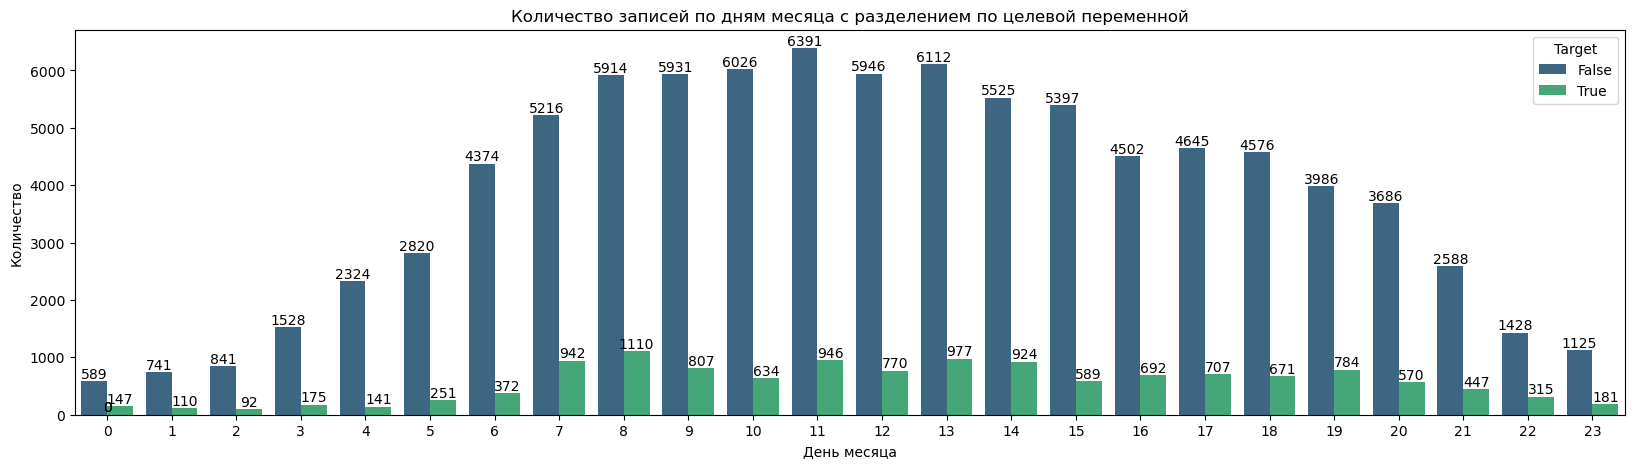

In [24]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df_train_pr, x='order_hour', hue='target', palette='viridis')
plt.title('Количество записей по дням месяца с разделением по целевой переменной')
plt.xlabel('День месяца')
plt.ylabel('Количество')
plt.legend(title='Target')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}',  
                (p.get_x() + p.get_width() / 2., height),  
                ha='center', va='bottom')  

plt.show()


In [25]:
df_train_pr.drop('order_year', axis=1, inplace=True)
df_test_pr.drop('order_year', axis=1, inplace=True)

- Нет очевидной зависимости между мошенническими заказами и **годами** или **временем суток**.

#### total_ordered

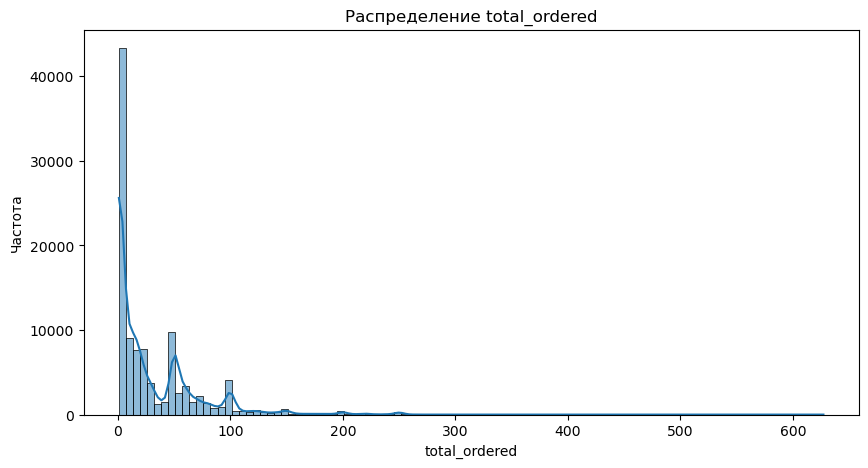

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='total_ordered', kde=True, bins=100)
plt.title(f'Распределение {'total_ordered'}')
plt.xlabel('total_ordered')
plt.ylabel('Частота')
plt.show()

- данные имеют положительную асимметрию, типичную для заказов, трат, товаров и т.п. 

#### PaymentType

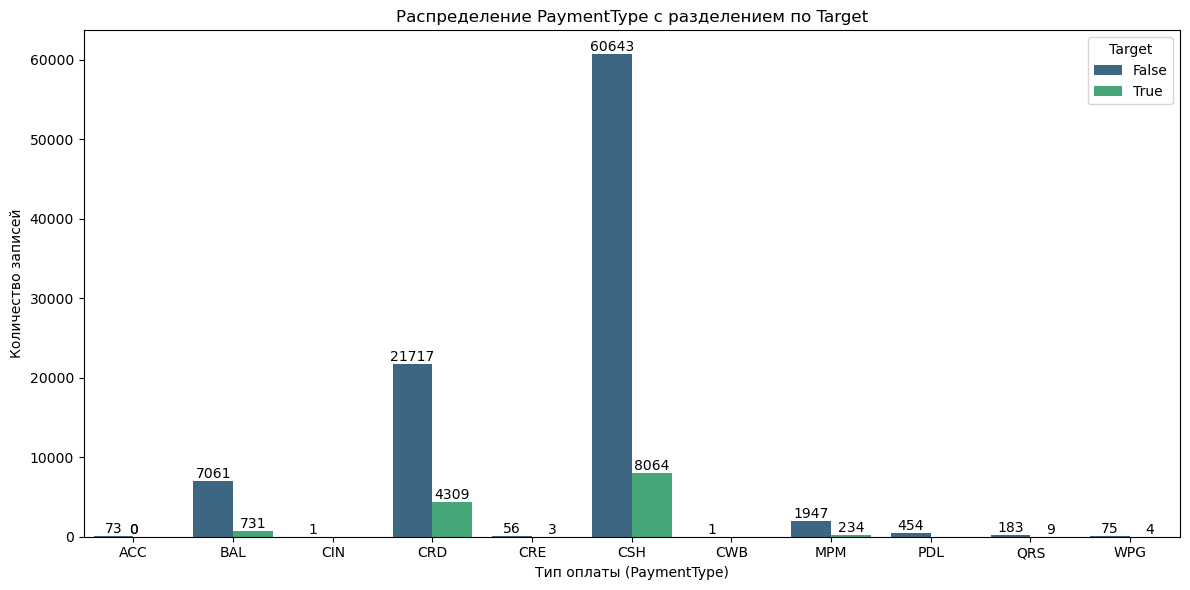

In [27]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train_pr, x='PaymentType', hue='target', palette='viridis')
plt.title(f'Распределение PaymentType с разделением по Target')
plt.xlabel('Тип оплаты (PaymentType)')
plt.ylabel('Количество записей')
plt.legend(title='Target')


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

- чаще всего пользователи оплачивают заказы наличными
- нет явной взаимосвязи между способом оплаты и мошенническим заказом 

#### IsPaid

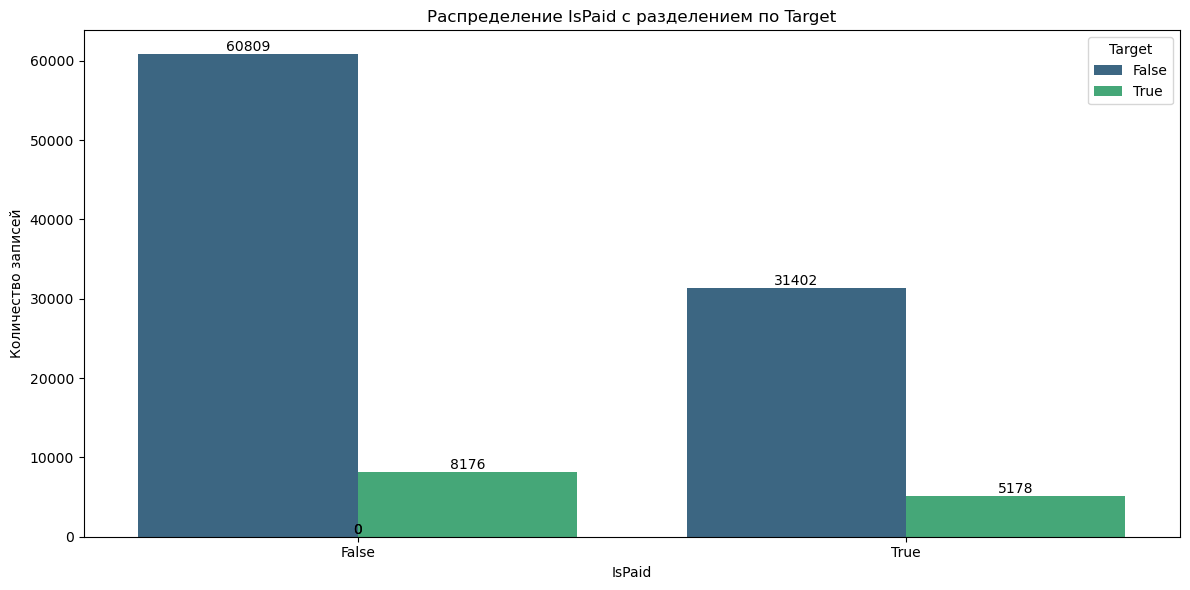

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train_pr, x='IsPaid', hue='target', palette='viridis') 
plt.title(f'Распределение IsPaid с разделением по Target')
plt.xlabel('IsPaid')
plt.ylabel('Количество записей')
plt.legend(title='Target')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

- чаще всего пользователи при оформлении заказа не оплачивают его
- нет явной взаимосвязи между фактом оплаты заказа и мошенническим заказом

#### service

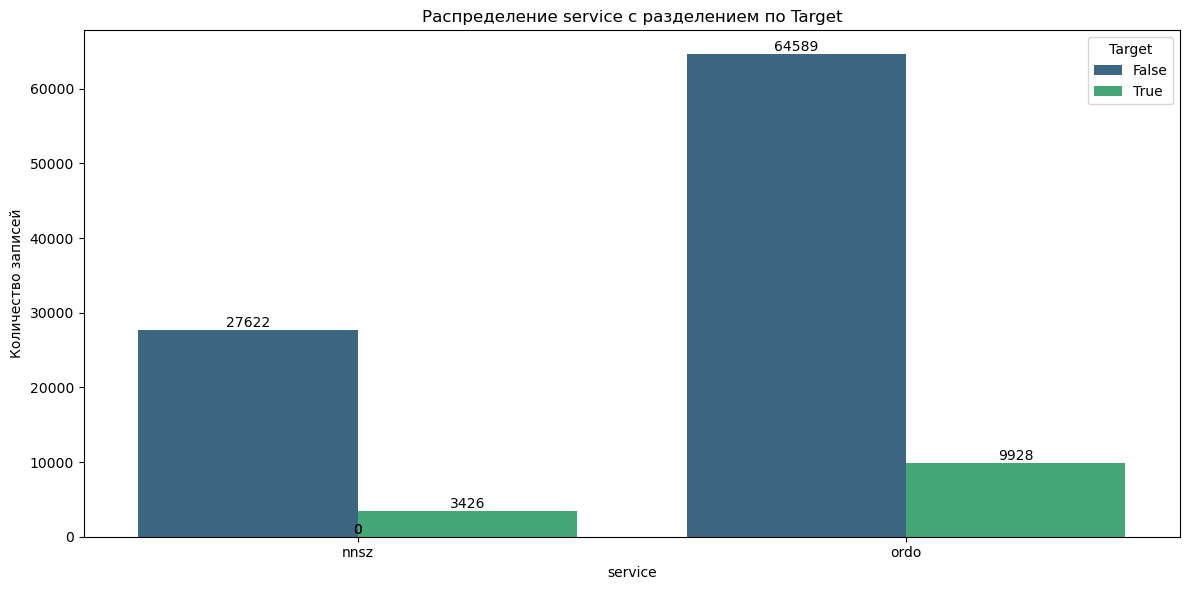

In [29]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train_pr, x='service', hue='target', palette='viridis') 
plt.title(f'Распределение service с разделением по Target')
plt.xlabel('service')
plt.ylabel('Количество записей')
plt.legend(title='Target')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

- нет явной взаимосвязи между типом региона и мошенническими заказами

#### count_items

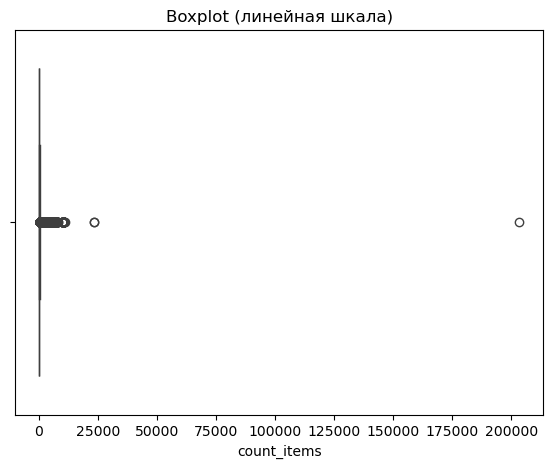

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train_pr['count_items'])
plt.title('Boxplot (линейная шкала)')

plt.show()

- значение признака count_items = 203303 это выброс, попозже удалим его

#### unique_items

Text(0.5, 1.0, 'Boxplot unique_items')

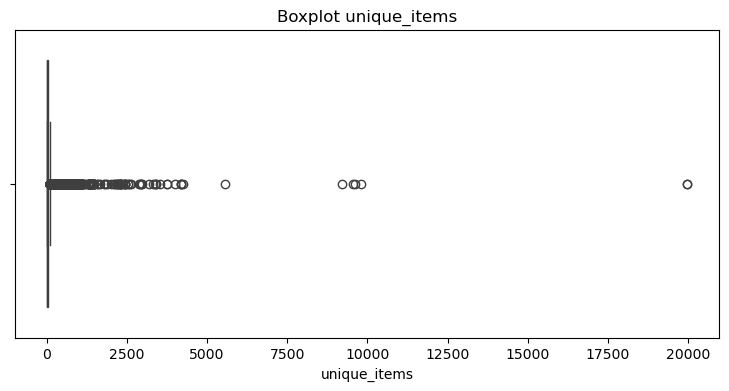

In [ ]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train_pr['unique_items'])
plt.title('Boxplot unique_items')

In [31]:
df_train_pr[df_train_pr['unique_items'] > 18000]

service  total_ordered PaymentType  IsPaid  count_items  unique_items  \
2155    ordo            150         CRD    True        23295         19984   
3051    ordo            130         CRD    True        23295         19984   

      avg_unique_purchase  is_courier  NmAge  Distance  DaysAfterRegistration  \
2155                 0.85       False   1184       335                    726   
3051                 0.85       False     78      1534                    726   

      number_of_orders  number_of_ordered_items  mean_number_of_ordered_items  \
2155                 1                      150                         150.0   
3051                 1                      130                         130.0   

      min_number_of_ordered_items  max_number_of_ordered_items  \
2155                          150                          150   
3051                          130                          130   

      mean_percent_of_ordered_items  target  order_hour  
2155                          100.0   False          12  
3051                          100.0   False          12

- Это выбросы, удалим их попозже

#### avg_unique_purchase

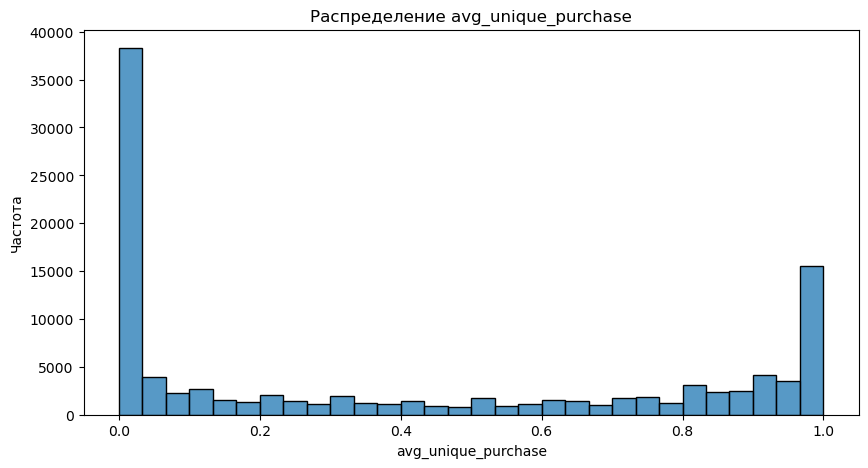

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='avg_unique_purchase', bins=30)
plt.title(f'Распределение {'avg_unique_purchase'}')
plt.xlabel('avg_unique_purchase')
plt.ylabel('Частота')
plt.show()

#### is_courier

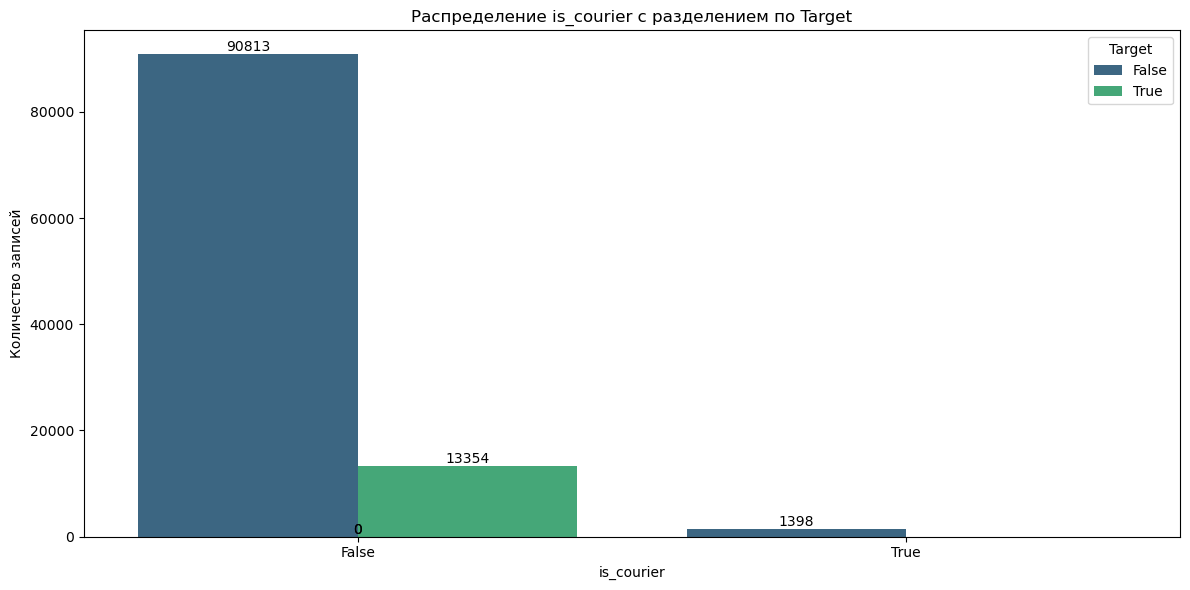

In [38]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train_pr, x='is_courier', hue='target', palette='viridis')
plt.title(f'Распределение is_courier с разделением по Target')
plt.xlabel('is_courier')
plt.ylabel('Количество записей')
plt.legend(title='Target')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

- мошеннические заказы без доставки курьером

#### NmAge

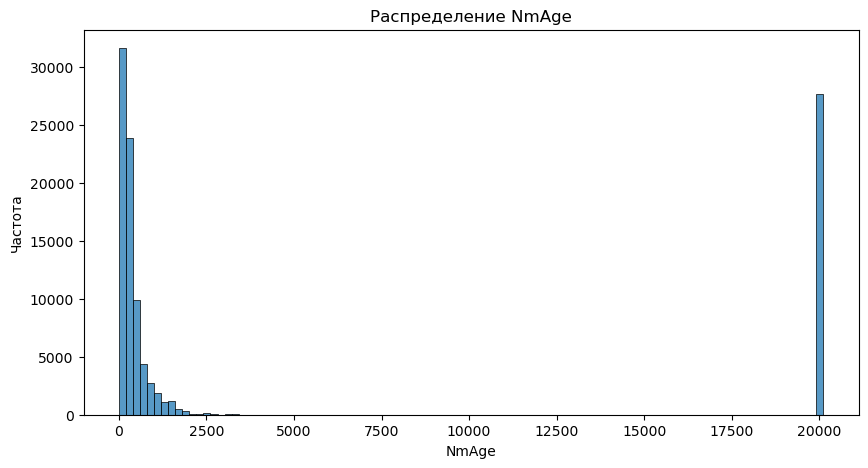

In [42]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='NmAge', bins=100)
plt.title(f'Распределение {'NmAge'}')
plt.xlabel('NmAge')
plt.ylabel('Частота')
plt.show()

Существует большое количество аккаунтов с большим NmAge, похоже на выбросы, но если мы построим такой же график на df_test, то увидим то же самое, так что оставим

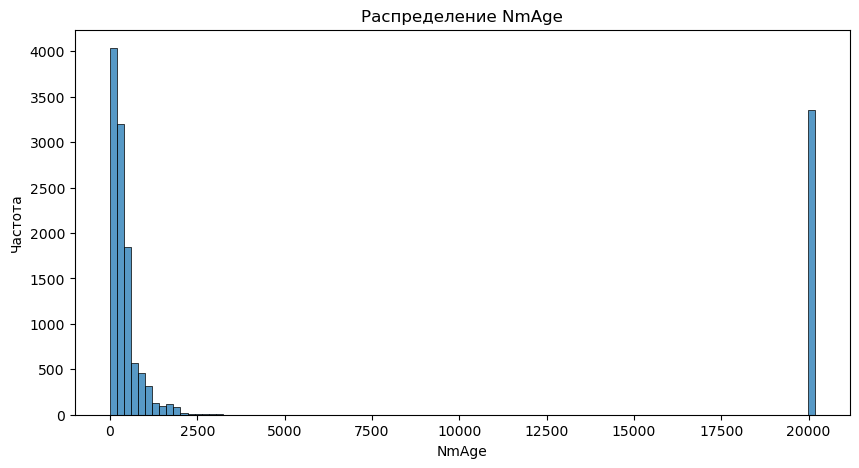

In [41]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_test_pr, x='NmAge', bins=100)
plt.title(f'Распределение {'NmAge'}')
plt.xlabel('NmAge')
plt.ylabel('Частота')
plt.show()

#### Distance

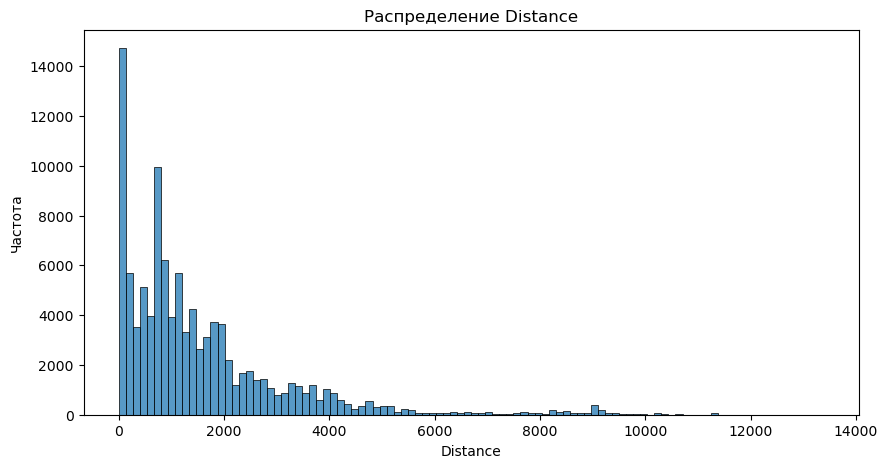

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='Distance', bins=100)
plt.title(f'Распределение {'Distance'}')
plt.xlabel('Distance')
plt.ylabel('Частота')
plt.show()

#### DaysAfterRegistration

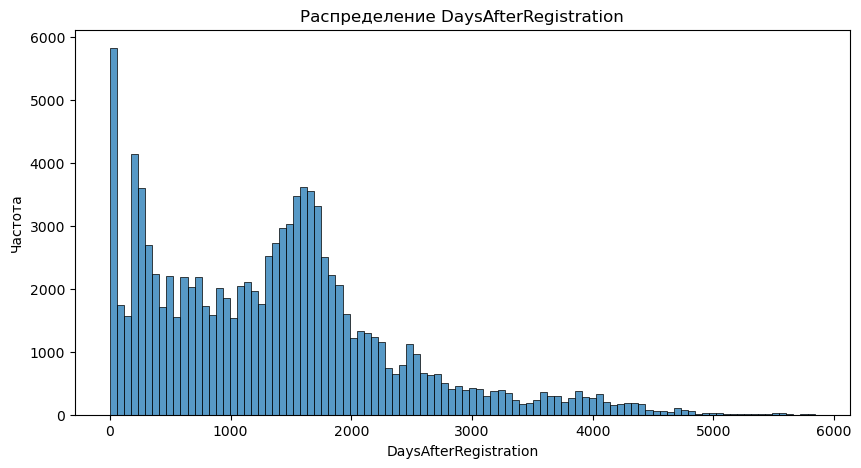

In [45]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='DaysAfterRegistration', bins=100)
plt.title(f'Распределение {'DaysAfterRegistration'}')
plt.xlabel('DaysAfterRegistration')
plt.ylabel('Частота')
plt.show()

#### mean_number_of_ordered_items

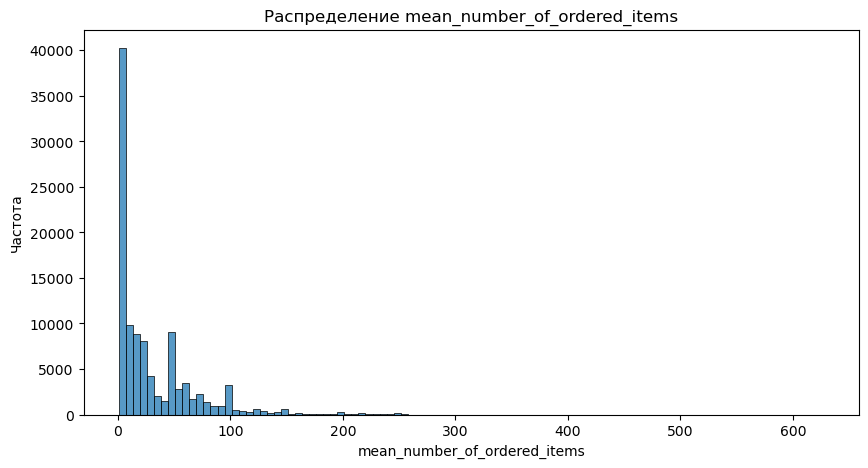

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='mean_number_of_ordered_items', bins=100)
plt.title(f'Распределение {'mean_number_of_ordered_items'}')
plt.xlabel('mean_number_of_ordered_items')
plt.ylabel('Частота')
plt.show()

#### max_number_of_ordered_items

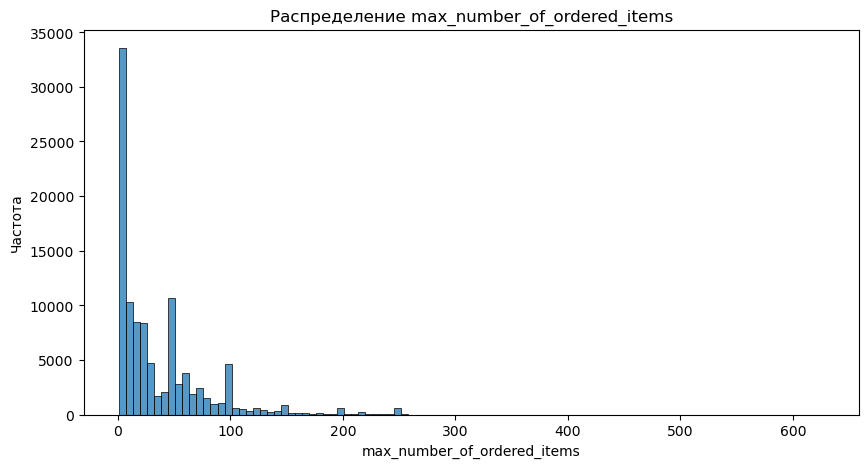

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='max_number_of_ordered_items', bins=100)
plt.title(f'Распределение {'max_number_of_ordered_items'}')
plt.xlabel('max_number_of_ordered_items')
plt.ylabel('Частота')
plt.show()

#### min_number_of_ordered_items

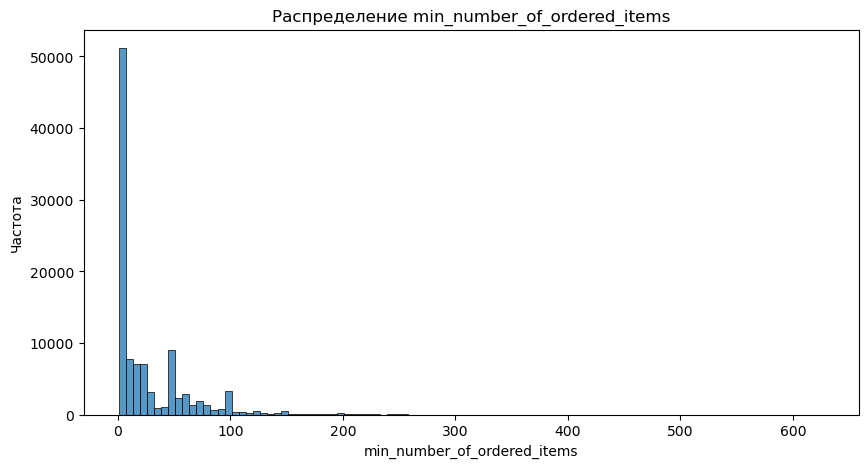

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train_pr, x='min_number_of_ordered_items', bins=100)
plt.title(f'Распределение {'min_number_of_ordered_items'}')
plt.xlabel('min_number_of_ordered_items')
plt.ylabel('Частота')
plt.show()

### Корреляция

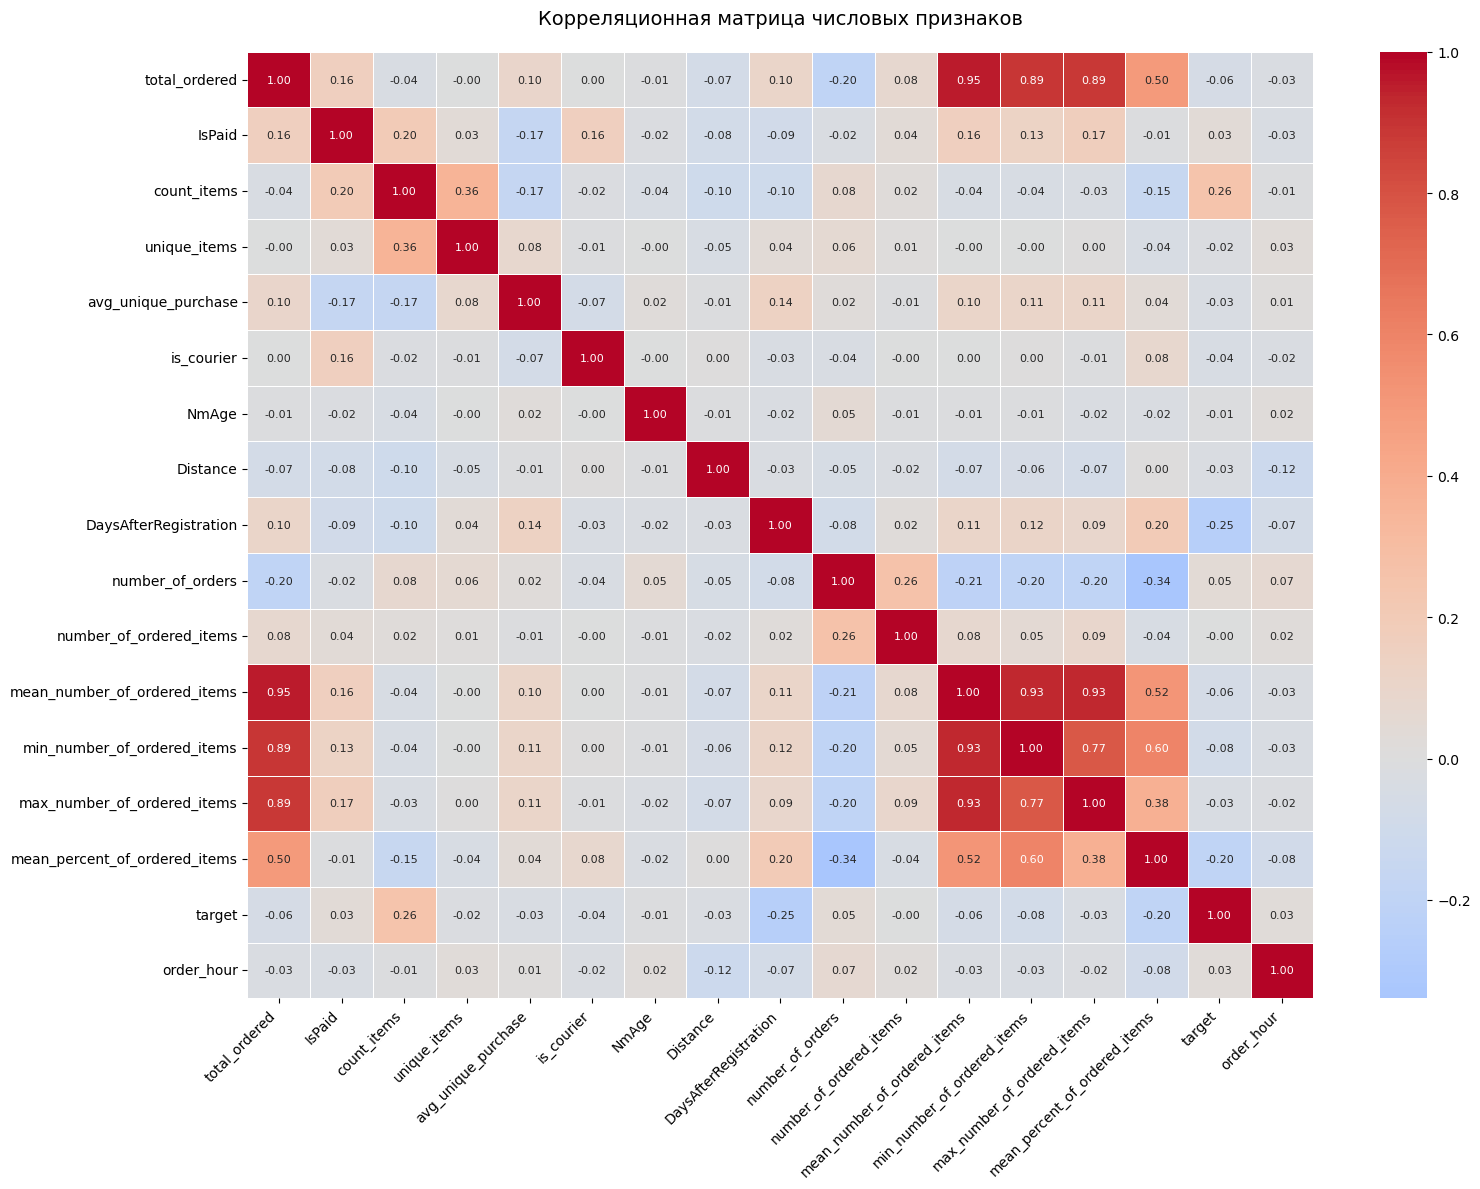

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    df_train_pr.corr(numeric_only=True),
    annot=True,      
    fmt=".2f",       
    cmap="coolwarm",
    center=0,      
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Корреляционная матрица числовых признаков", pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

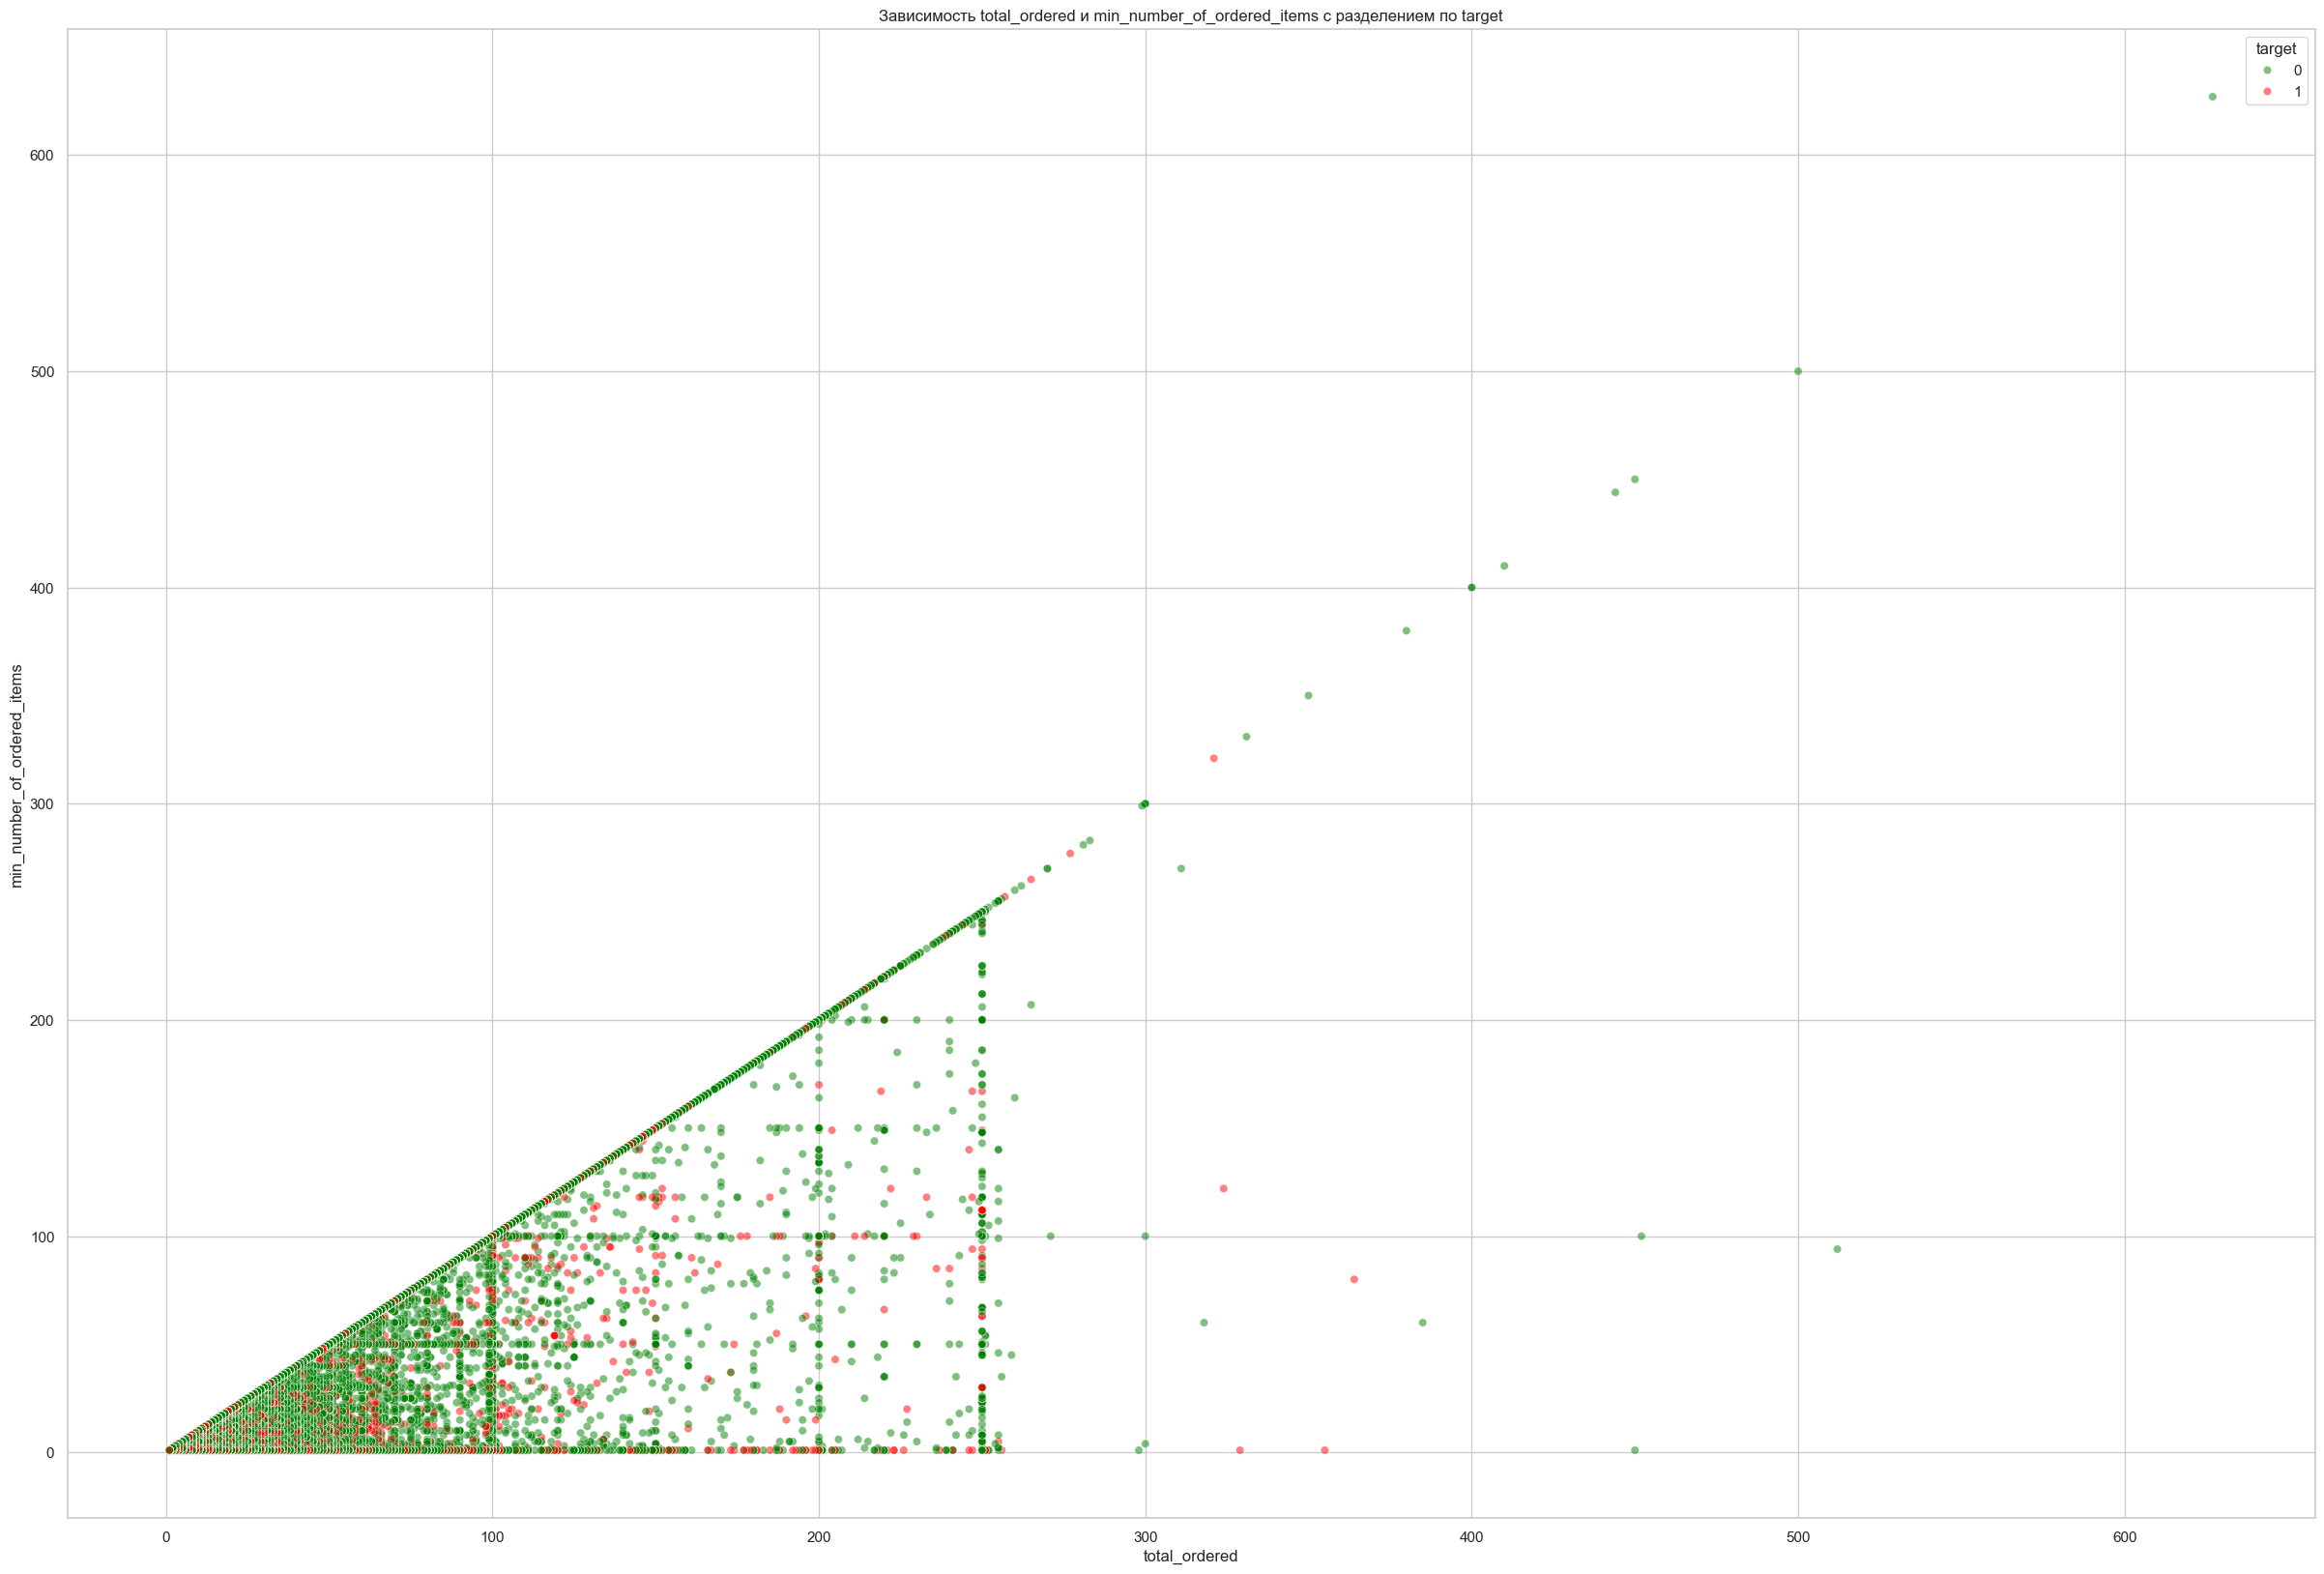

In [ ]:
plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=df_train_pr,
    x='total_ordered',
    y='min_number_of_ordered_items',
    hue='target',
    palette={0: 'green', 1: 'red'},
    alpha=0.5
)
plt.title('Зависимость total_ordered и min_number_of_ordered_items с разделением по target')
plt.show()

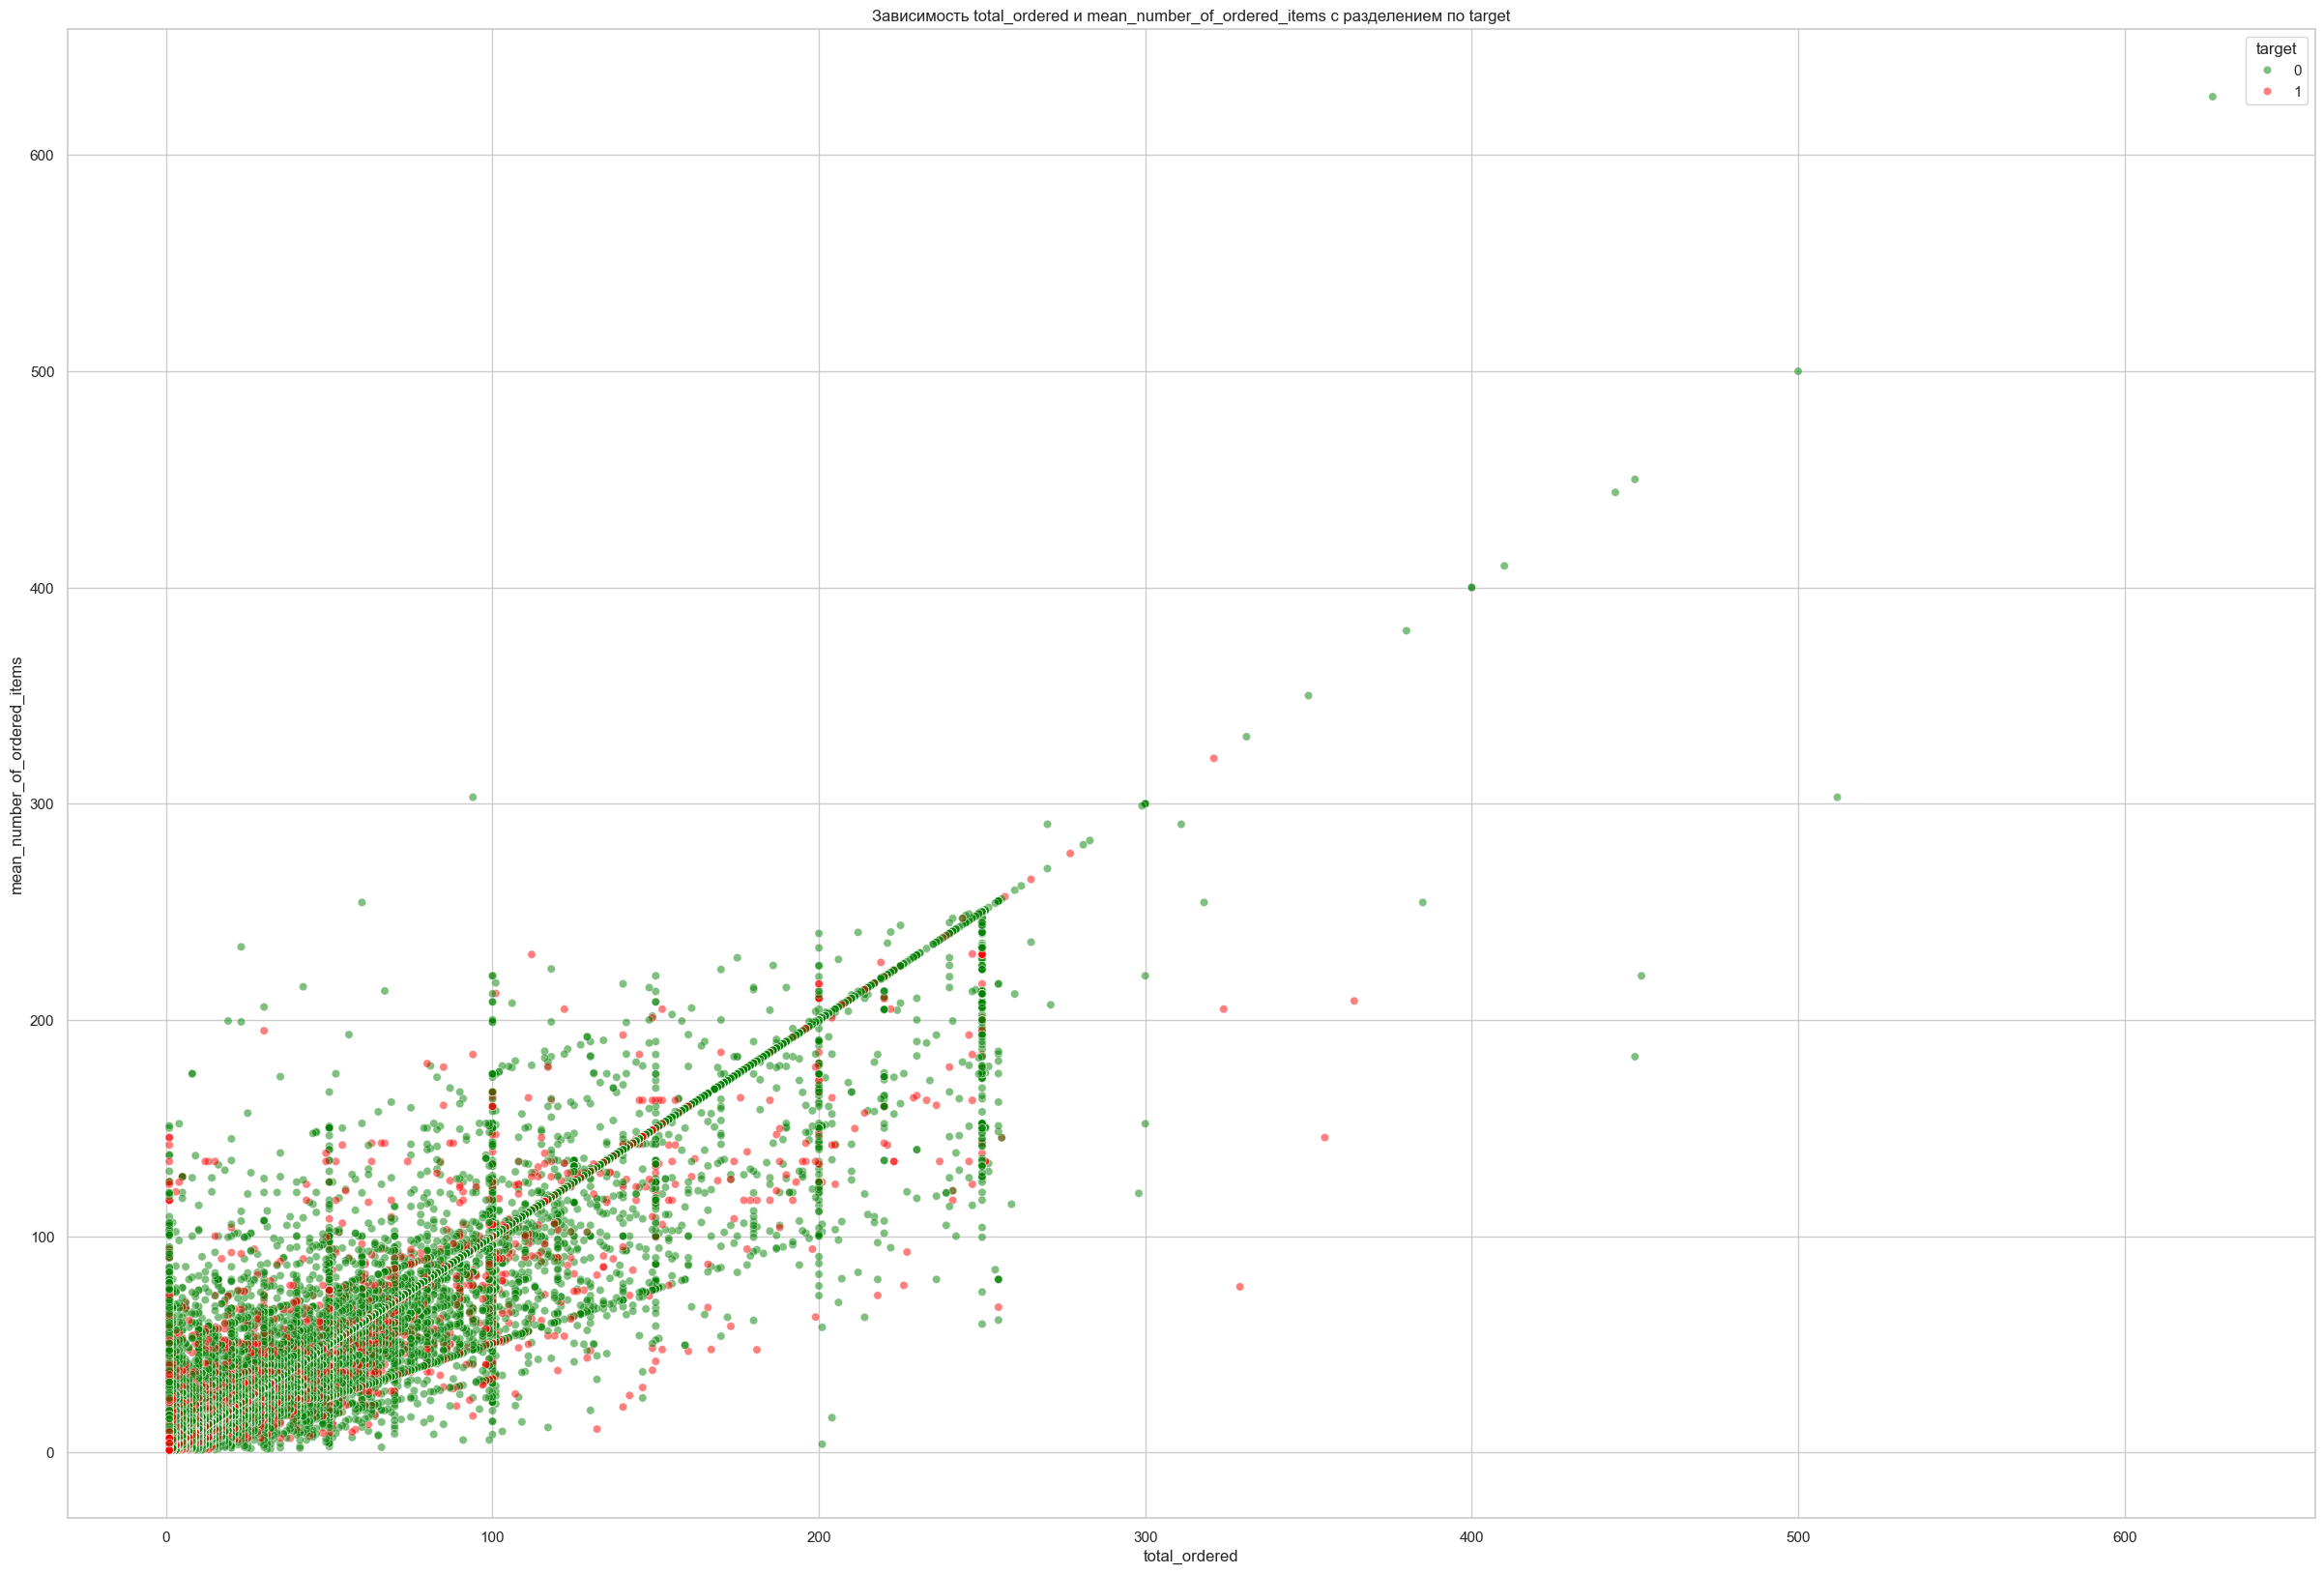

In [ ]:
plt.figure(figsize=(30, 20))
sns.scatterplot(
    data=df_train_pr,
    x='total_ordered',
    y='mean_number_of_ordered_items',
    hue='target',
    palette={0: 'green', 1: 'red'},
    alpha=0.5
)
plt.title('Зависимость total_ordered и mean_number_of_ordered_items с разделением по target')
plt.show()

Некоторые переменные достаточно сильно взаимосвязаны между собой  
При обучении baseline модели можно попробовать удалить зависимые между собой признаки, чтобы избежать мультиколлинеарности и интерпретируемость модели была выше  
Также при обучении KNN удалим зависимые признаки, так как они будут вредить обучению  
Для RandomForest и Catboost мультиколлинеарность не является большой проблемой

# Предобработка данных:

●	Обработка пропущенных значений

●	Обработка выбросов

●	Кодирование категориальных признаков

●	Масштабирование числовых признаков

●	Работа с дисбалансом классов (SMOTE, undersampling, class weights и т.д.)




### Обработка пропущенных значений

In [54]:
#подсчет пропусков в датафрейме
missing_cols_train = df_train.isnull().sum()
missing_cols_train = missing_cols_train[missing_cols_train > 0]
print('Количество пропущенных значений в df_train', len(missing_cols_train))

missing_cols_test = df_test.isnull().sum()
missing_cols_test = missing_cols_test[missing_cols_test > 0]
print('Количество пропущенных значений в df_test', len(missing_cols_test))

Количество пропущенных значений в df_train 0
Количество пропущенных значений в df_test 0


Пропусков в данных нет, так что перейдем к кодированию категориальных признаков

### Обработка выбросов

Датасет имеет всего 3 выброса, которые я бы удалил

In [58]:
df_train_pr.shape

(105565, 19)

In [60]:
df_train_pr = df_train_pr[(df_train_pr['count_items'] < 200000) & (df_train_pr['unique_items'] < 18000)]

### Кодирование категориальных признаков

In [56]:
df_train_pr['service'].unique()

['nnsz', 'ordo']
Categories (2, object): ['nnsz', 'ordo']

In [57]:
df_train_pr['PaymentType'].unique()

['CSH', 'CRD', 'BAL', 'QRS', 'MPM', ..., 'WPG', 'PDL', 'ACC', 'CIN', 'CWB']
Length: 11
Categories (11, object): ['ACC', 'BAL', 'CIN', 'CRD', ..., 'MPM', 'PDL', 'QRS', 'WPG']

В рассматриваемом датасете присутствуют два категориальных признака с ограниченным числом уникальных значений и отсутствием выраженного порядка (иерархии) между категориями. В связи с этим, для корректного включения этих признаков в модели машинного обучения будет использован метод One-Hot Encoding  
Для catboost модели не будем обрабатывать категориальные признаки, а передадим параметр cat_indices

### Масштабирование числовых признаков

Для моделей, чувствительных к масштабу и размерности признакового пространства — таких как логистическая регрессия и алгоритм k ближайших соседей — целесообразно применять предварительное стандартизирование признаков с использованием StandardScaler. В то же время для алгоритмов, таких как Random Forest и CatBoost, масштабирование данных не требуется, поскольку они не используют расстояния между точками.  
  
Масштабирование числовых признаков будет осуществляться непосредственно в процессе построения модели с использованием пайплайнов (Pipeline)

### Работа с дисбалансом классов

Для борьбы с дисбалансом классов в целевой переменной при обучении моделей будет использован параметр class_weight, позволяющий скорректировать вклад каждого класса в функцию потерь.

# Обучение моделей

Начнем с baseline модели - логистической регрессии

Удалять перед обучением коррелирующие признаки не будем, так как с ними модель показывает себя лучше

In [105]:
X = df_train_pr.drop(columns='target')
y = df_train_pr['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [106]:
cat_features = ['service', 'PaymentType']
num_features = ['total_ordered', 'count_items', 'unique_items', 'avg_unique_purchase', 'NmAge', 'Distance', 'DaysAfterRegistration', 'number_of_orders',
                'number_of_ordered_items', 'mean_number_of_ordered_items', 'min_number_of_ordered_items', 'max_number_of_ordered_items', 'mean_percent_of_ordered_items',
                'order_hour']
bool_features = ['IsPaid', 'is_courier']
target = 'target'

In [ ]:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bool_pipeline = Pipeline([
    ('passthrough', 'passthrough') 
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    ('num', num_pipeline, num_features),
    ('bool', bool_pipeline, bool_features)
])

In [108]:
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000000, solver='liblinear', class_weight='balanced', random_state=42))
])

logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['service', 'PaymentType']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['total_ordered',
                                                   'count_items',
                                                   'unique_items',
                                                   'avg_unique_purchase',
                                                   'NmAge', 'Distance',
                                                   'DaysAfterRegistration',...
                                                   'number_of_ordered_items',
                                                   'mean_number_of_ordered_items',
                                                   'min_number_of_ordered_items',
                                                   'max_number_of_ordered_items',
                                                   'mean_percent_of_ordered_items',
                                                   'order_hour']),
                                                 ('bool',
                                                  Pipeline(steps=[('passthrough',
                                                                   'passthrough')]),
                                                  ['IsPaid', 'is_courier'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000000,
                                    random_state=42, solver='liblinear'))])

In [ ]:
def get_results(model, X_test, y_test):
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_preds, digits=4))
    print("F1-score:", f1_score(y_test, y_preds))

    fpr, tpr, _ = roc_curve(y_test, y_preds_proba)
    roc_auc = roc_auc_score(y_test, y_preds_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"ROC AUC: {roc_auc:.4f}")

    precision, recall, _ = precision_recall_curve(y_test, y_preds_proba)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"PR AUC: {pr_auc:.4f}")

    print("\nConfusion Matrix:")
    print(ConfusionMatrixDisplay.from_predictions(y_test, y_preds))


Classification Report:
              precision    recall  f1-score   support

       False     0.9563    0.7650    0.8501     23012
        True     0.3226    0.7621    0.4533      3379

    accuracy                         0.7647     26391
   macro avg     0.6395    0.7635    0.6517     26391
weighted avg     0.8752    0.7647    0.7993     26391

F1-score: 0.4533051667986973


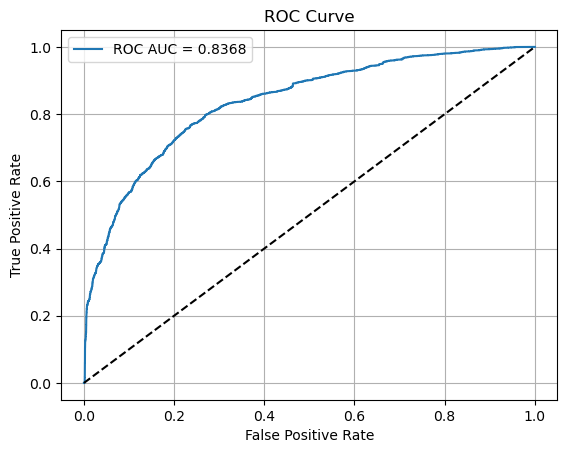

ROC AUC: 0.8368


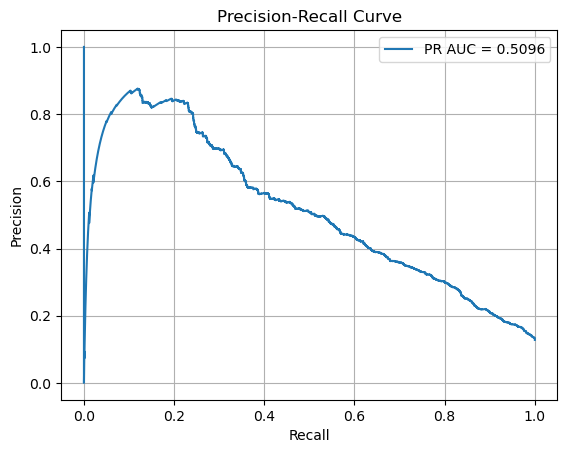

PR AUC: 0.5096

Confusion Matrix:


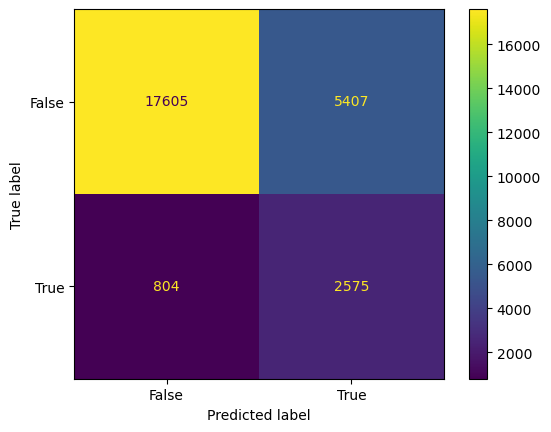

In [110]:
get_results(logistic_pipeline, X_test, y_test)

Модель хорошо захватывает положительные примеры (высокий recall), но она делает много ложных срабатываний (низкий precision).

Перейдем к модели catboost и подберем гиперпараметры

In [ ]:
counter = Counter(y_train)
total = sum(counter.values())
weights = {cls: total / count for cls, count in counter.items()}

In [85]:
weights

{False: 1.144155731545176, True: 7.936942355889724}

In [87]:
params = {'l2_leaf_reg': [l for l in [3, 5, 7, 8]],
          'learning_rate': [lr for lr in [0.1, 0.5, 0.05, 0.6]], 
           'max_depth':[d for d in range(4,9)]} 

catboost = CatBoostClassifier(subsample=0.8, 
                        eval_metric='F1',
                        early_stopping_rounds=20,
                        cat_features=cat_features, 
                        thread_count=-1,
                        class_weights=[1.1, 7.9])

search_results = catboost.grid_search(params, X_train, y_train, cv=3, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7199996	test: 0.7245223	best: 0.7245223 (0)	total: 229ms	remaining: 3m 48s
1:	learn: 0.7577196	test: 0.7575839	best: 0.7575839 (1)	total: 264ms	remaining: 2m 11s
2:	learn: 0.7394884	test: 0.7417148	best: 0.7575839 (1)	total: 300ms	remaining: 1m 39s
3:	learn: 0.7384047	test: 0.7419721	best: 0.7575839 (1)	total: 338ms	remaining: 1m 24s
4:	learn: 0.7568893	test: 0.7534971	best: 0.7575839 (1)	total: 374ms	remaining: 1m 14s
5:	learn: 0.7661593	test: 0.7637551	best: 0.7637551 (5)	total: 403ms	remaining: 1m 6s
6:	learn: 0.7680500	test: 0.7627730	best: 0.7637551 (5)	total: 437ms	remaining: 1m 1s
7:	learn: 0.7727745	test: 0.7658950	best: 0.7658950 (7)	total: 467ms	remaining: 57.9s
8:	learn: 0.7753442	test: 0.7670662	best: 0.7670662 (8)	total: 500ms	remaining: 55s
9:	learn: 0.7756202	test: 0.7655180	best: 0.7670662 (8)	total: 526ms	remaining: 52s
10:	learn: 0.7791104	test: 0.7710798	best: 0.7710798 (10)	total: 551ms	remaining: 49.5s
11:	learn: 0.7855809	test: 0.7766585	best: 0.776658

In [88]:
search_results['params']

{'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3}

In [ ]:
catboost  = CatBoostClassifier(subsample=0.8, 
                        eval_metric='F1',
                        early_stopping_rounds=20,
                        cat_features=cat_features, 
                        thread_count=-1,
                        class_weights=[1.1, 7.9],
                        depth=8,
                        learning_rate=0.1,
                        l2_leaf_reg=3)
catboost.fit(X_train, y_train)

0:	learn: 0.8050015	total: 62.8ms	remaining: 1m 2s
1:	learn: 0.8232982	total: 104ms	remaining: 52s
2:	learn: 0.8453397	total: 155ms	remaining: 51.4s
3:	learn: 0.8430540	total: 181ms	remaining: 45.2s
4:	learn: 0.8500520	total: 214ms	remaining: 42.7s
5:	learn: 0.8528696	total: 253ms	remaining: 41.9s
6:	learn: 0.8545530	total: 319ms	remaining: 45.2s
7:	learn: 0.8587512	total: 408ms	remaining: 50.6s
8:	learn: 0.8606699	total: 458ms	remaining: 50.4s
9:	learn: 0.8621733	total: 517ms	remaining: 51.2s
10:	learn: 0.8662402	total: 561ms	remaining: 50.5s
11:	learn: 0.8692231	total: 605ms	remaining: 49.8s
12:	learn: 0.8713409	total: 636ms	remaining: 48.3s
13:	learn: 0.8720526	total: 666ms	remaining: 46.9s
14:	learn: 0.8744979	total: 712ms	remaining: 46.8s
15:	learn: 0.8767608	total: 748ms	remaining: 46s
16:	learn: 0.8808762	total: 780ms	remaining: 45.1s
17:	learn: 0.8837777	total: 833ms	remaining: 45.4s
18:	learn: 0.8866965	total: 877ms	remaining: 45.3s
19:	learn: 0.8884427	total: 912ms	remaining:


Classification Report:
              precision    recall  f1-score   support

       False     0.9869    0.9859    0.9864     23012
        True     0.9045    0.9106    0.9075      3379

    accuracy                         0.9762     26391
   macro avg     0.9457    0.9483    0.9470     26391
weighted avg     0.9763    0.9762    0.9763     26391

F1-score: 0.9075357616870667


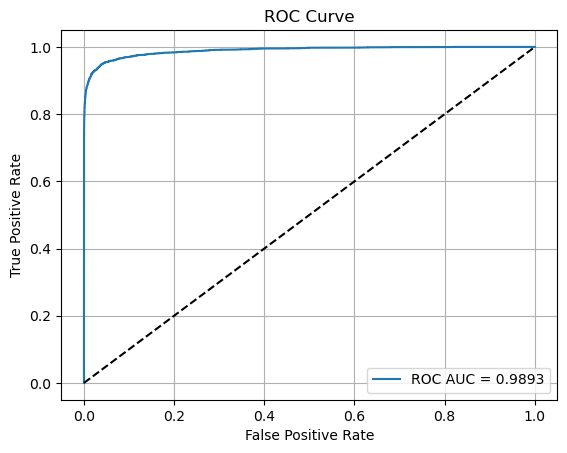

ROC AUC: 0.9893


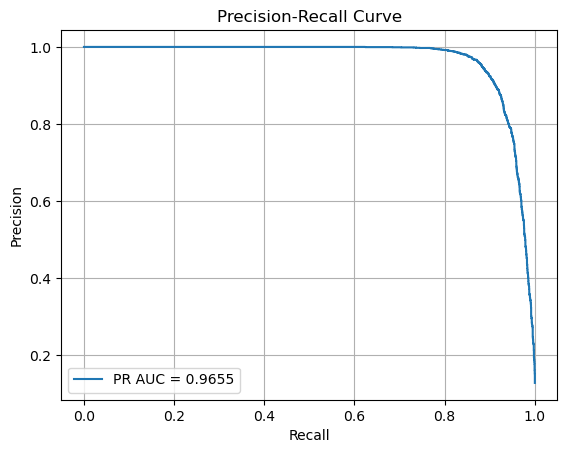

PR AUC: 0.9655

Confusion Matrix:


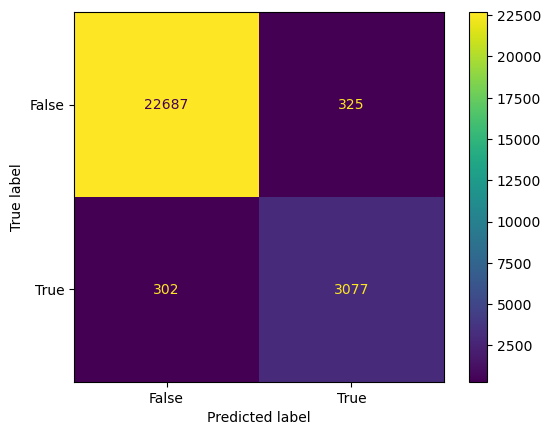

In [127]:
get_results(catboost, X_test, y_test)

Модель показала достаточно хорошие результаты: f1-score = 0.9075  
Попробуем обучить RandomForestClassifier и алгоритм k ближайших соседей и применим стэкинг для этих моделей

---

In [ ]:
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', rf)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

rf_grid_search.fit(X_train, y_train)
rf_model = rf_grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   3.3s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   3.4s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   3.5s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   3.7s
[CV] END classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   6.4s
[CV] END classifier__max_depth=4, classifier__min_s

In [112]:
rf_grid_search.best_params_

{'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

       False     0.9808    0.9422    0.9611     23012
        True     0.6895    0.8745    0.7710      3379

    accuracy                         0.9335     26391
   macro avg     0.8351    0.9083    0.8661     26391
weighted avg     0.9435    0.9335    0.9368     26391

F1-score: 0.7710371819960862


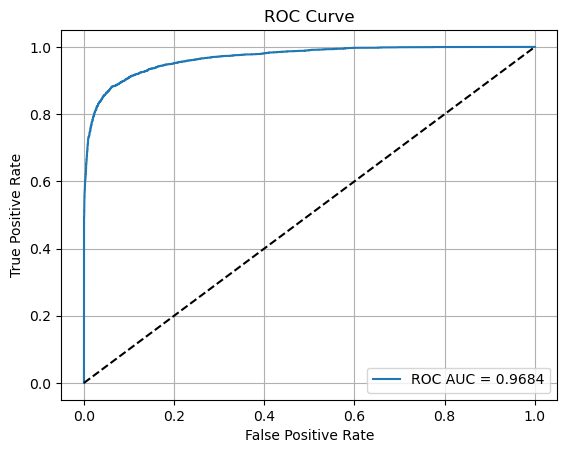

ROC AUC: 0.9684


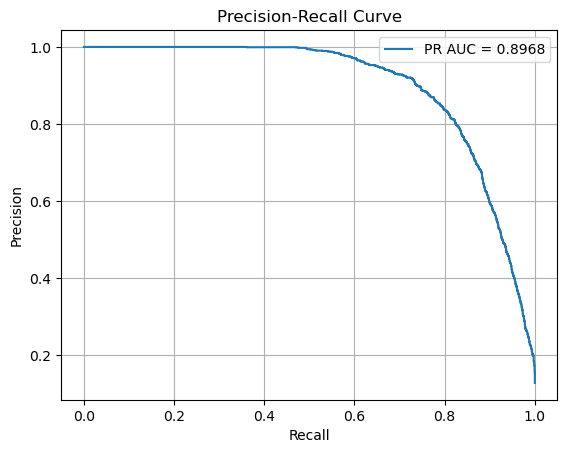

PR AUC: 0.8968

Confusion Matrix:


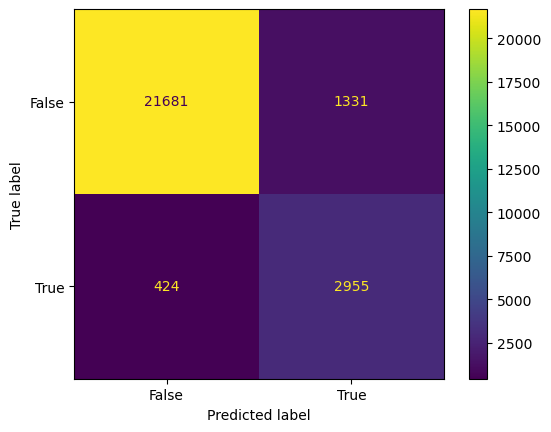

In [113]:
get_results(rf_model, X_test, y_test)

---

Обучим KNN

In [ ]:
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

knn_pipeline = Pipeline(steps=[
    ('preprocessor', knn_preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

knn_grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)


knn_grid_search.fit(X_train, y_train)
knn_model = knn_grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance; total time=   9.8s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance; total time=   9.8s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance; total time=  10.0s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform; total time=  10.7s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=  10.8s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform; total time=  10.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=uniform; total time=  11.0s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=  11.1s
[CV] END classifier__met

In [118]:
knn_grid_search.best_params_

{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 5,
 'classifier__weights': 'distance'}


Classification Report:
              precision    recall  f1-score   support

       False     0.9771    0.9920    0.9845     23012
        True     0.9389    0.8417    0.8876      3379

    accuracy                         0.9727     26391
   macro avg     0.9580    0.9168    0.9361     26391
weighted avg     0.9722    0.9727    0.9721     26391

F1-score: 0.8876404494382022


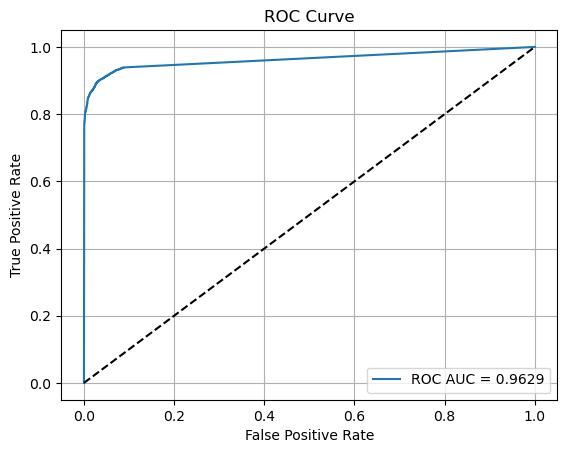

ROC AUC: 0.9629


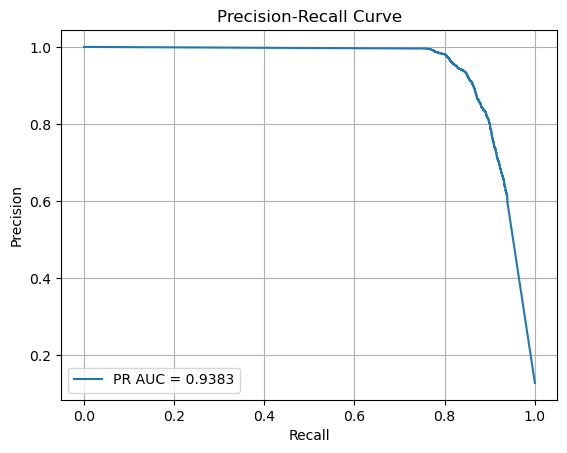

PR AUC: 0.9383

Confusion Matrix:


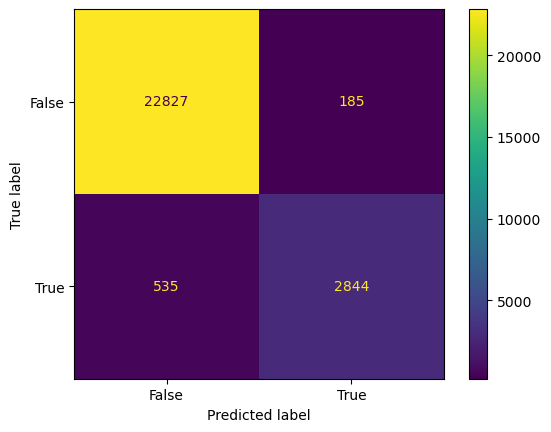

In [119]:
get_results(knn_model, X_test, y_test)

----

Теперь попробуем объединить эти модели, в качесте метамодели возьмем логистическую регрессию

In [140]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
meta_train = np.zeros((X_train.shape[0], 3))
meta_test = np.zeros((X_test.shape[0], 3))
cat_stack = CatBoostClassifier(subsample=0.8, 
                        eval_metric='F1',
                        early_stopping_rounds=20,
                        cat_features=cat_features, 
                        thread_count=-1,
                        class_weights=[1.1, 7.9],
                        depth=8,
                        learning_rate=0.1,
                        l2_leaf_reg=3)
rf_stack = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('rf_model_stack', RandomForestClassifier(max_depth=10,
                                  min_samples_leaf=1,
                                  min_samples_split=5,
                                  n_estimators=200, 
                                  random_state=42, 
                                  class_weight='balanced', 
                                  n_jobs=-1))])

knn_stack = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('knn_model_stack', KNeighborsClassifier(metric='manhattan',
                                             n_neighbors=5,
                                             weights='distance'))])

for i, model in enumerate([cat_stack, rf_stack, knn_stack]):
    test_fold_preds = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_train[val_idx, i] = model.predict(X_val_fold)
        test_fold_preds.append(model.predict(X_test))

    meta_test[:, i] = np.mean(test_fold_preds, axis=0)

final_model = LogisticRegression(max_iter=1000)
final_model.fit(meta_train, y_train)

0:	learn: 0.7921338	total: 33.5ms	remaining: 33.4s
1:	learn: 0.8237136	total: 78.4ms	remaining: 39.1s
2:	learn: 0.8352270	total: 113ms	remaining: 37.7s
3:	learn: 0.8405297	total: 143ms	remaining: 35.7s
4:	learn: 0.8474039	total: 172ms	remaining: 34.2s
5:	learn: 0.8474724	total: 198ms	remaining: 32.9s
6:	learn: 0.8503145	total: 224ms	remaining: 31.8s
7:	learn: 0.8552950	total: 248ms	remaining: 30.8s
8:	learn: 0.8563388	total: 273ms	remaining: 30.1s
9:	learn: 0.8663403	total: 296ms	remaining: 29.3s
10:	learn: 0.8677696	total: 321ms	remaining: 28.8s
11:	learn: 0.8686838	total: 350ms	remaining: 28.8s
12:	learn: 0.8722243	total: 373ms	remaining: 28.3s
13:	learn: 0.8731172	total: 394ms	remaining: 27.8s
14:	learn: 0.8771022	total: 414ms	remaining: 27.2s
15:	learn: 0.8803109	total: 435ms	remaining: 26.8s
16:	learn: 0.8806567	total: 455ms	remaining: 26.3s
17:	learn: 0.8833545	total: 477ms	remaining: 26s
18:	learn: 0.8846989	total: 501ms	remaining: 25.9s
19:	learn: 0.8857501	total: 523ms	remaini

LogisticRegression(max_iter=1000)


Classification Report:
              precision    recall  f1-score   support

       False     0.9800    0.9933    0.9866     23012
        True     0.9498    0.8621    0.9038      3379

    accuracy                         0.9765     26391
   macro avg     0.9649    0.9277    0.9452     26391
weighted avg     0.9761    0.9765    0.9760     26391

F1-score: 0.9038163201985728


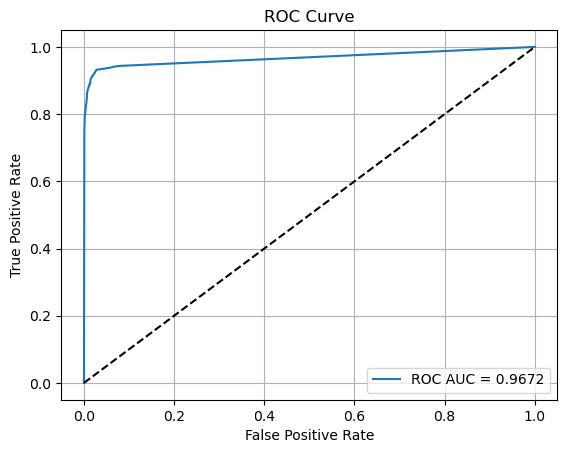

ROC AUC: 0.9672


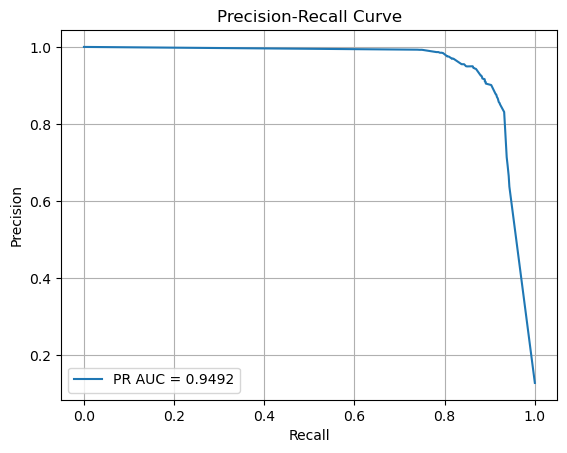

PR AUC: 0.9492

Confusion Matrix:


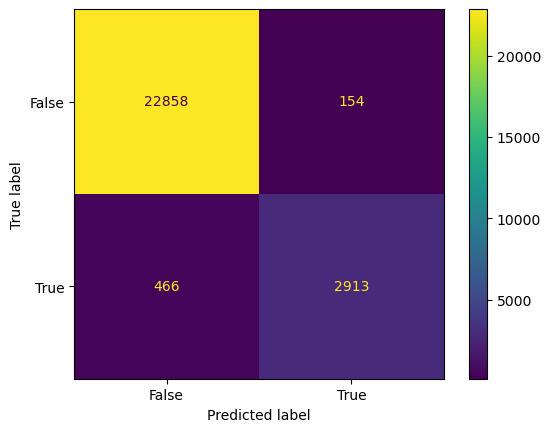

In [141]:
get_results(final_model, meta_test, y_test)

В данном случае стэкинг показывает результат немного хуже, чем отдельно catboost, поэтому в качестве итоговой модели возьмем CatBoostClassifier

In [129]:
catboost.get_params()

{'learning_rate': 0.1,
 'depth': 8,
 'l2_leaf_reg': 3,
 'class_weights': [1.1, 7.9],
 'eval_metric': 'F1',
 'subsample': 0.8,
 'early_stopping_rounds': 20,
 'cat_features': ['service', 'PaymentType']}

Сделаем предсказание на df_test

In [131]:
df_test_pr = preprocess(df_test)

In [134]:
df_test_pr.drop(columns='order_year', inplace=True)

In [135]:
df_test_pr

service  total_ordered PaymentType  IsPaid  count_items  unique_items  \
0        nnsz            854         CSH   False            0             0   
1        ordo            534         QRS   False          125            33   
2        ordo            472         CRD    True            0             0   
3        ordo            440         CSH   False         2212             9   
4        nnsz            400         CSH   False            0             0   
...       ...            ...         ...     ...          ...           ...   
14256    ordo              1         BAL    True           78            73   
14257    ordo              1         MPM   False            1             1   
14258    ordo              1         MPM   False            1             1   
14259    ordo              1         MPM   False            1             1   
14260    ordo              1         CSH   False            0             0   

       avg_unique_purchase  is_courier  NmAge  Distance  \
0                     0.00       False    114       913   
1                     0.26       False    143       105   
2                     0.00       False    578        94   
3                     0.00       False   1928      1849   
4                     0.00       False     43      2331   
...                    ...         ...    ...       ...   
14256                 0.93       False    924       120   
14257                 1.00       False    214       518   
14258                 1.00       False    214       518   
14259                 1.00       False    214       518   
14260                 0.00       False   1762      1430   

       DaysAfterRegistration  number_of_orders  number_of_ordered_items  \
0                       1078                 1                      854   
1                       2792                 5                     1062   
2                         29                 1                      472   
3                       1349                 1                      440   
4                       2168                 1                      400   
...                      ...               ...                      ...   
14256                   1804                15                       67   
14257                    960                48                       60   
14258                    960                48                       60   
14259                    960                48                       60   
14260                      0                 2                       64   

       mean_number_of_ordered_items  min_number_of_ordered_items  \
0                        854.000000                          854   
1                        212.400000                           88   
2                        472.000000                          472   
3                        440.000000                          440   
4                        400.000000                          400   
...                             ...                          ...   
14256                      4.466667                            1   
14257                      1.250000                            1   
14258                      1.250000                            1   
14259                      1.250000                            1   
14260                     32.000000                            1   

       max_number_of_ordered_items  mean_percent_of_ordered_items  target  \
0                              854                     100.000000    True   
1                              534                      20.000000   False   
2                              472                     100.000000    True   
3                              440                     100.000000   False   
4                              400                     100.000000   False   
...                            ...                            ...     ...   
14256                           20                       6.666667   False   
14257         

In [136]:
X_valid = df_test_pr.drop('target', axis=1)
y_valid = df_test_pr['target']


Classification Report:
              precision    recall  f1-score   support

       False     0.8980    0.9408    0.9189     12455
        True     0.3919    0.2630    0.3148      1806

    accuracy                         0.8550     14261
   macro avg     0.6450    0.6019    0.6168     14261
weighted avg     0.8339    0.8550    0.8424     14261

F1-score: 0.3147779986746189


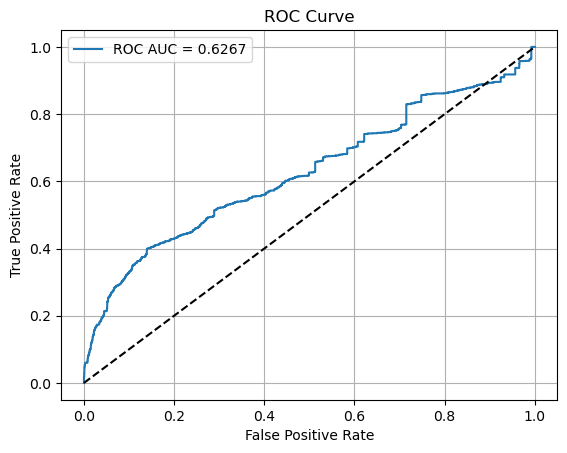

ROC AUC: 0.6267


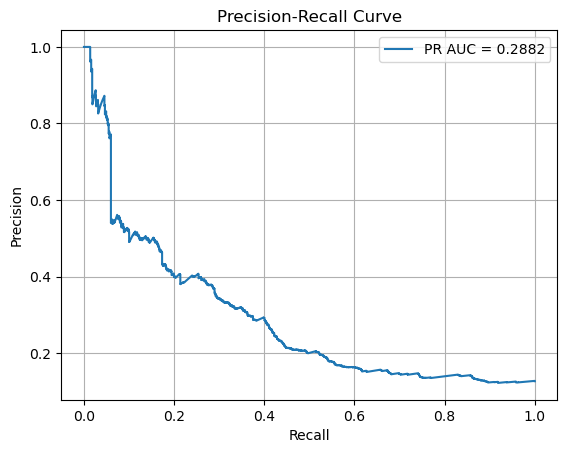

PR AUC: 0.2882

Confusion Matrix:


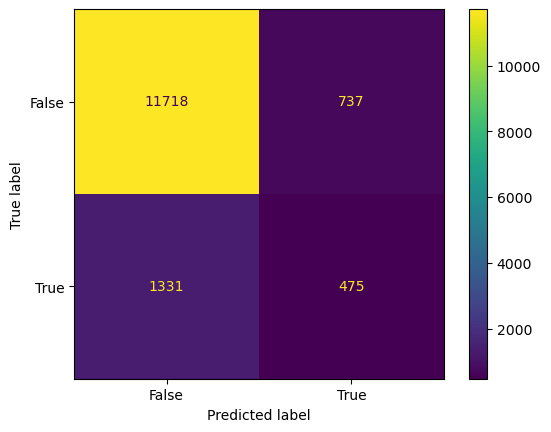

In [137]:
get_results(catboost, X_valid, y_valid)

На тестовом датасете метрики значительно просели